# Coco Assembly and Ribosome Collision

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
temp_repo_dir = "/home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/"
data_repo_dir = "/home/kai/HDD_Kemal/from_raf_computer/Kemal/Data/sam_bukau"
script_path_infrastructure = "/home/kai/HDD_Kemal/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure"
import sys
sys.path.insert(0, '/home/kai/HDD_Kemal/from_raf_computer/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

spt = [os.path.join(data_repo_dir, i) for i in ["Sixtymers_TT1.sam", "Sixtymers_TT2.sam"]]
sps = [os.path.join(data_repo_dir, i) for i in ["Sixtymers_Rep1.sam", "Sixtymers_Rep2.sam", "Sixtymers_NoPK.sam"]]

erb_serb = [os.path.join(data_repo_dir, f"SeRP/EBP1/Rep{i+1}/IP/IP{i+1}.sam") for i in range(2)]
erb_total = [os.path.join(data_repo_dir, f"SeRP/EBP1/Rep{i+1}/Total/Total{i+1}.sam") for i in range(2)]
nac_serb = [os.path.join(data_repo_dir, f"SeRP/NAC/Rep{i+1}/IP/IP{i+1}.sam") for i in range(2)]
nac_total = [os.path.join(data_repo_dir, f"SeRP/NAC/Rep{i+1}/Total/Total{i+1}.sam") for i in range(2)]

coco_d = [os.path.join(data_repo_dir, i) for i in ["Coco_Dis1.sam", "Coco_Dis2.sam"]]
coco_m = [os.path.join(data_repo_dir, i) for i in ["Coco_Mono1.sam", "Coco_Mono2.sam"]]

exclude_genes = ["ENSG00000160789"]

I = Infrastructre(temp_repo_dir,
                  exclude_genes=exclude_genes,
                  ensembl_release=102,
                  organism="homo_sapiens",
                  #include_gene3d=True,
                  verbose=True)
I.riboseq_sixtymers = RiboSeqSixtymers(I.temp_repo_dir, spt, sps, "sixtymers",
                                        riboseq_assign_to="best_transcript", riboseq_assign_at="auto",
                                        protein_genome_instance=I.protein_genome,
                                        gene_info_dictionary=I.gene_info,
                                        exclude_genes=I.exclude_genes, verbose=I.verbose)
# Should be first to calculate, since multiprocessing is quite memory inefficient.
I.riboseq_coco = RiboSeqCoco(I.temp_repo_dir, coco_m, coco_d, "cocoassembly",
                             riboseq_assign_to="best_transcript", riboseq_assign_at=-15,
                             protein_genome_instance=I.protein_genome,
                             gene_info_dictionary=I.gene_info,
                             exclude_genes=I.exclude_genes, verbose=I.verbose)

/home/kai/anaconda3/envs/kemals/lib/python3.6/site-packages/ipykernel_launcher.py:26: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


[05/05/2021 20:13:08 CEST] Gene information dictionary is found in path: /home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/gene_info_database.joblib


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/Homo_sapiens.GRCh38.cdna.all.fa.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/Homo_sapiens.GRCh38.pep.all.fa.pickle


[05/05/2021 20:13:33 CEST] ProteinGenome found in path: /home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/protein_genome_instance.joblib
[05/05/2021 20:13:42 CEST] RiboSeq assignment for sixtymers_background found in path: /home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/riboseq_sixtymers_background.joblib
[05/05/2021 20:13:46 CEST] RiboSeq assignment for sixtymers_experiment found in path: /home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/riboseq_sixtymers_experiment.joblib
[05/05/2021 20:13:52 CEST] RiboSeq assignment for cocoassembly_background found in path: /home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/riboseq_cocoassembly_background.joblib
[05/05/2021 20:13:55 CEST] RiboSeq assignment for cocoassembly_experiment found in path: /home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/riboseq_cocoassembly_experiment.joblib
Fitting calculations found for cocoassembly in path: /home/kai/HDD_Kemal/from_raf_computer/Kemal/Temp/human/riboseq_cocoassembly_fitting_c

In [3]:
gene_collision = {gene_id: I.riboseq_sixtymers.stalling_peaks_inecik_3(gene_id, probability=0.010) for gene_id in I.gene_list}

In [4]:
gene_lengths = {gene_id: I.riboseq_coco.experiment.gene_lengths[gene_id] for gene_id in I.gene_list}

In [5]:
print(f"Number of collision sites: {len([j for i in gene_collision for j in gene_collision[i]])}") # 35732

Number of collision sites: 34135


In [6]:
def bootstrap(data, n=1000, func=np.mean, p=0.95):
    data = data[~np.isnan(data)]
    # Bootstrap is conducted by sampling with replacement
    sample_size = len(data)
    simulations = [func(np.random.choice(data, size=sample_size, replace=True)) for i in range(n)]
    low_ci = np.percentile(simulations, 100*(1-p)/2)
    high_ci = np.percentile(simulations, 100*(1-(1-p)/2))
    return (low_ci, high_ci)
def normalization(data1d):
    return (data1d - np.nanmin(data1d)) / (np.nanmax(data1d) - np.nanmin(data1d))
def confidence_interval_normal(metag, confidence=0.95):
    ci = np.empty((2, metag.shape[1]))
    for i in range(metag.shape[1]):
        data = metag[:, i]
        mean=np.nanmean(data)
        std=np.nanstd(data, ddof=1)
        size=np.sum(~np.isnan(data))
        alpha=1-confidence
        t_score=stats.t.isf(alpha/2,df=(size-1))
        ME=t_score*std/np.sqrt(size)
        lower_CI=mean-ME
        upper_CI=mean+ME
        ci[:,i] = np.array([lower_CI, upper_CI])
    return ci
def confidence_interval_poission(metag, confidence=0.95):
    # https://stats.stackexchange.com/questions/15371/how-to-calculate-a-confidence-level-for-a-poisson-distribution
    ci = np.empty((2, metag.shape[1]))
    for i in range(metag.shape[1]):
        data = metag[:, i]
        mean=np.nanmean(data)
        z=stats.norm.ppf(1-(1-confidence)/2)
        size=np.sum(~np.isnan(data))
        lower_CI=mean - z * np.sqrt(mean/size)
        upper_CI=mean + z * np.sqrt(mean/size)
        ci[:,i] = np.array([lower_CI, upper_CI])
    return ci

#### CocoOnset

Choose the one of following

In [7]:
filtered_onset = "all" # all, high, low

In [8]:
gene_onset_raw = {gene_id: I.riboseq_coco.calculate_onset(gene_id) for gene_id in I.gene_list}
print(f"Gene count: {len(I.gene_list)}")
print(f"Genes does not fit CocoAssembly: {np.isnan(np.array(list(gene_onset_raw.values()))).sum()}")
print(f"Genes fit CocoAssembly: {len(I.gene_list) - np.isnan(np.array(list(gene_onset_raw.values()))).sum()}")

/home/kai/HDD_Kemal/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1975: RuntimeWarning: overflow encountered in exp
  ((1 - i_final) / (1 + np.exp(-a_2 * (x - (i_mid + i_dist)))) + i_final)
/home/kai/HDD_Kemal/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1974: RuntimeWarning: overflow encountered in exp
  return ((i_max - i_init) / (1 + np.exp(-a_1 * (x - i_mid))) + i_init) * \
/home/kai/HDD_Kemal/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1970: RuntimeWarning: overflow encountered in exp
  return (i_max - i_init) / (1 + np.exp(-a * (x - i_mid))) + i_init


Gene count: 22524
Genes does not fit CocoAssembly: 15604
Genes fit CocoAssembly: 6920


In [9]:
pubdata = pd.read_excel(os.path.join(os.path.dirname(script_path_infrastructure), "matilde_kai_2021.xlsx"), header=1)
pubdata["Low_conf"] = pubdata["Low_conf"].astype(bool)
pubdata["High_conf"] = pubdata["High_conf"].astype(bool)
if filtered_onset == "all":
    pass
elif filtered_onset == "high":
    pubdata = pubdata[pubdata["High_conf"] == True]
elif filtered_onset == "low":
    pubdata = pubdata[pubdata["Low_conf"] == True]
else:
    raise AssertionError

print(pubdata[:2])
print(f"\nData frame shape: {pubdata.shape}")

   Gene  Onset [codons]  High_conf  Low_conf  Expression [RPKM]
0  AAAS             155       True     False           0.121248
1  AACS             101       True     False           0.023634

Data frame shape: (4130, 5)


Pearson Correlation: 0.9356792640026654
Number of Filtered Conf Ensembl IDs: 4121


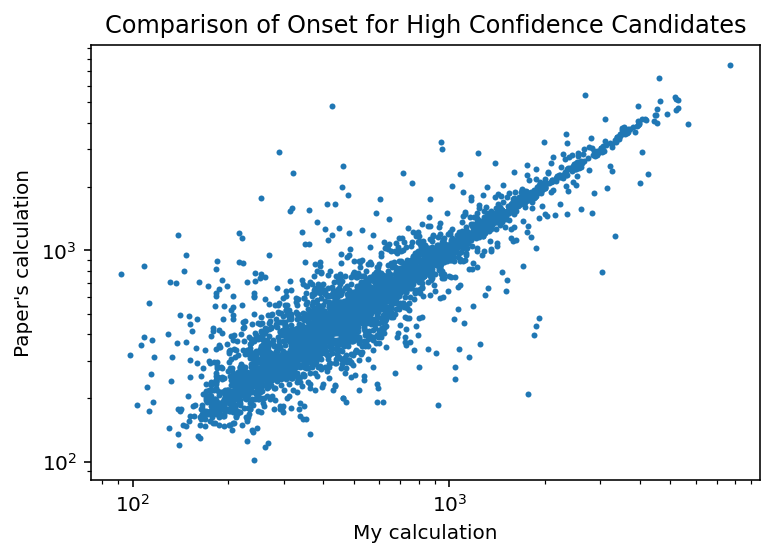

In [10]:
gene_name_to_gene_id = dict()
for gene_id in I.gene_list:
    for gene_name in I.gene_info[gene_id].gene_names:
        gene_name_to_gene_id[gene_name] = gene_name_to_gene_id.get(gene_name, []) + [gene_id]

toensembl = dict()
for gene_name in pubdata["Gene"]:
    if gene_name in gene_name_to_gene_id:
        toensembl[gene_name] = gene_name_to_gene_id[gene_name]
    else:
        for k in gene_name.split("-"):
            if k in gene_name_to_gene_id:
                toensembl[gene_name] = toensembl.get(gene_name, []) + gene_name_to_gene_id[k]
    if gene_name in toensembl:
        toensembl[gene_name] = [gene_id for gene_id in toensembl[gene_name] if not np.isnan(gene_onset_raw[gene_id])]

filtered_conf_list = list()
comparison = list()
for gene_name in toensembl:
    for gene_id in toensembl[gene_name]:
        comparison.append([gene_onset_raw[gene_id], int(pubdata["Onset [codons]"][pubdata["Gene"] == gene_name])*3])
        filtered_conf_list.append(gene_id)
comparison = np.array(comparison).T

plt.scatter(comparison[0], comparison[1], linewidths=0, marker=".")
plt.xscale("log"); plt.xlabel("My calculation")
plt.yscale("log"); plt.ylabel("Paper's calculation")
plt.title("Comparison of Onset for High Confidence Candidates")

print(f"Pearson Correlation: {stats.pearsonr(comparison[0], comparison[1])[0]}")
print(f"Number of Filtered Conf Ensembl IDs: {len(filtered_conf_list)}")

Difference can be attributed to the difference in selecting CDS.

In [11]:
gene_onset = gene_onset_raw.copy()
for gene_id in gene_onset:
    if gene_id not in filtered_conf_list:
        gene_onset[gene_id] = np.nan

## Ribosome colision signal enrichment around onset 

In [12]:
rpkm_threshold_for_sixtymers = 1

In [13]:
number_of_offset = 0
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    rpkm_background = I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id)
    if not np.isnan(ons) and rpkm_background > rpkm_threshold_for_sixtymers:
        number_of_offset += 1
number_of_offset

4085

In [14]:
flank = 400
metag = np.full((number_of_offset, flank * 2), np.nan)
ind = 0
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    rpkm_background = I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id)
    if not np.isnan(ons) and rpkm_background > rpkm_threshold_for_sixtymers:
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        normalized_sixtymers = exp_rpm_bs / rpkm_background
        start_position = max(0, ons-flank)
        start_offset = -min(0, ons-flank)
        marr = normalized_sixtymers[start_position: ons+flank]
        metag[ind, start_offset: len(marr) + start_offset] = marr
        ind += 1
ind

4085

In [15]:
# RANDOM Onset
onset_gene = 25
metag_average = np.full((number_of_offset * onset_gene, flank * 2), np.nan)
ind = 0
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    rpkm_background = I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id)
    if not np.isnan(ons) and rpkm_background > rpkm_threshold_for_sixtymers:
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        normalized_sixtymers = exp_rpm_bs / rpkm_background
        for _ in range(onset_gene):
            ons = np.random.randint(gene_lengths[gene_id])
            start_position = max(0, ons-flank)
            start_offset = -min(0, ons-flank)
            marr = normalized_sixtymers[start_position: ons+flank]
            metag_average[ind, start_offset: len(marr) + start_offset] = marr
            ind += 1
ind

102125

In [16]:
m1 = np.array([smooth_array(i, 15, "hanning") for i in metag])
m2 = np.array([smooth_array(i, 15, "hanning") for i in metag_average])
significance = list()
for i in range (flank*2):
    progress_bar(i, flank*2 - 1, verbose=True)
    m1_l = m1[:,i][~np.isnan(m1[:,i])]
    m2_l = m2[:,i][~np.isnan(m2[:,i])]
    significance.append(stats.mannwhitneyu(m1_l, m2_l).pvalue < 0.05 / (flank * 2))
significance = np.array(significance).astype(int)
## Ranges for plotting
signif_rnges = list()
first_element = False
for ind, i in enumerate(significance):
    if not first_element and i == 0:
        continue
    elif not first_element and i == 1:
        first_element = ind
    elif i == 0 or ind == len(significance) - 1:
        signif_rnges.append([first_element, ind - 1])
        first_element = False
    elif i == 1:
        continue
print(signif_rnges)

Progress: |████████████████████| 100.0% 
[[131, 134], [231, 240], [246, 438], [520, 607], [613, 725], [746, 747], [749, 750], [761, 793]]


In [17]:
kk = 0.95 
bootstrap_ci = confidence_interval_normal(metag, confidence=kk)
bootstrap_ci_random = confidence_interval_normal(metag_average, confidence=1-((1-kk) / onset_gene))

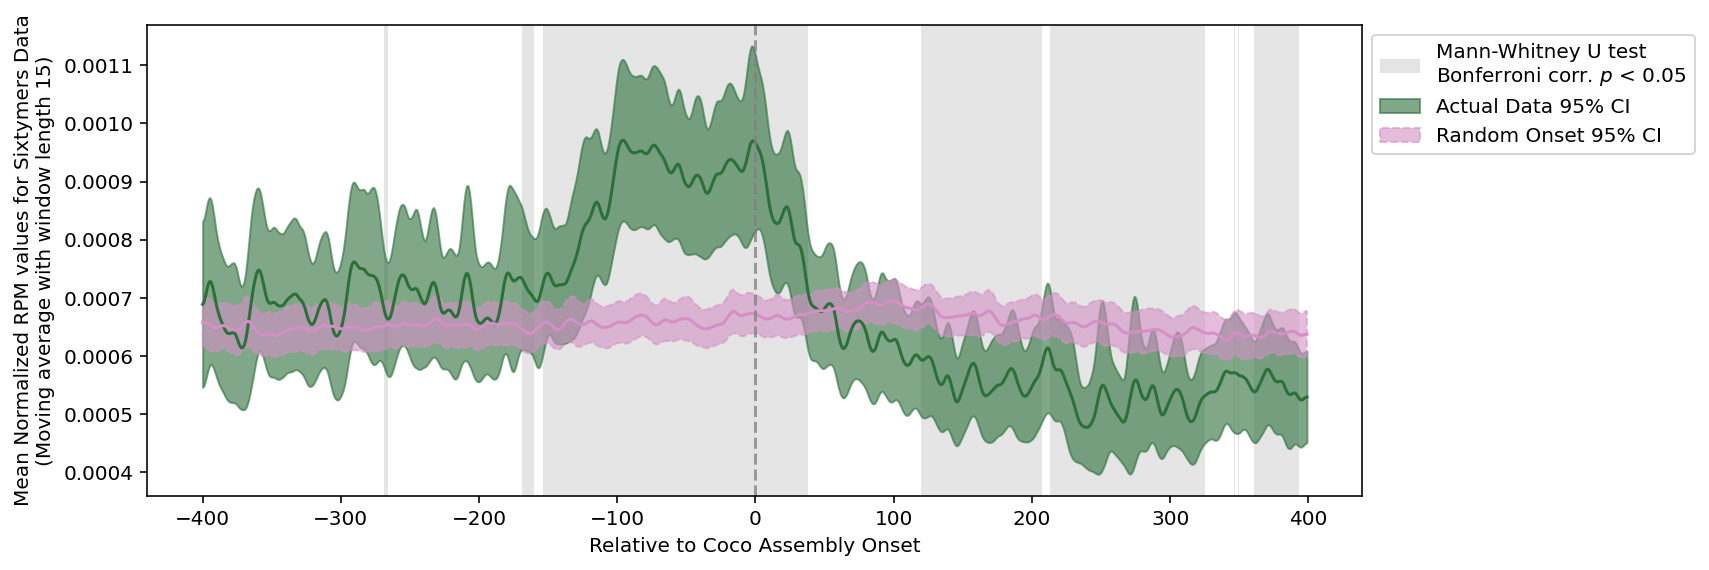

In [18]:
palette = sns.color_palette("cubehelix", 2)
plt.figure(figsize=(12,4))
x_data = np.array(range(-flank, flank))

plt.plot(x_data, smooth_array(np.nanmean(metag, axis=0), 15, "hanning"),
                color=palette[0], alpha=1)
plt.plot(x_data, smooth_array(np.nanmean(metag_average, axis=0), 15, "hanning"),
                color=palette[1], alpha=1)
plt.fill_between(x_data, smooth_array(bootstrap_ci[0],15, "hanning"), smooth_array(bootstrap_ci[1],15, "hanning"),
                color=palette[0], alpha=0.6, label="Actual Data 95% CI")
plt.fill_between(x_data, smooth_array(bootstrap_ci_random[0],15, "hanning"), smooth_array(bootstrap_ci_random[1],15, "hanning"),
                color=palette[1], alpha=0.6, linestyle="--", label="Random Onset 95% CI")
for i_rng, rng in enumerate(signif_rnges):
    plt.axvspan(rng[0] - flank, rng[1] - flank, color="gray", alpha=0.20, zorder=0, linewidth=0,
                label="Mann-Whitney U test\nBonferroni corr. $p$ < 0.05" if i_rng == 0 else "")
plt.axvline(0, color="gray", alpha=0.75, linestyle = "--")
plt.xlabel("Relative to Coco Assembly Onset")
plt.ylabel("Mean Normalized RPM values for Sixtymers Data\n(Moving average with window length 15)")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Ribosome colision peak enrichment around onset 

In [19]:
flank = 200
metag = np.full((number_of_offset, flank * 2), np.nan)
ind = 0
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    col = gene_collision[gene_id]
    rpkm_background = I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id)
    if not np.isnan(ons) and rpkm_background > rpkm_threshold_for_sixtymers:
        arr = np.arange(ons - flank, ons + flank)
        marr = np.isin(arr, col).astype(float)
        marr[arr < 0] = np.nan
        marr[arr > gene_lengths[gene_id]] = np.nan
        assert len(marr) == flank * 2
        metag[ind] = marr
        ind += 1
ind

4085

In [20]:
# RANDOM Onset
onset_gene = 25
metag_average = np.full((number_of_offset * onset_gene, flank * 2), np.nan)
ind = 0
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    col = gene_collision[gene_id]
    rpkm_background = I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id)
    if not np.isnan(ons) and rpkm_background > rpkm_threshold_for_sixtymers:
        for _ in range(onset_gene):
            ons = np.random.randint(gene_lengths[gene_id])
            arr = np.arange(ons - flank, ons + flank)
            marr = np.isin(arr, col).astype(float)
            marr[arr < 0] = np.nan
            marr[arr > gene_lengths[gene_id]] = np.nan
            assert len(marr) == flank * 2
            metag_average[ind] = marr
            ind += 1
ind

102125

In [21]:
m1 = np.array([smooth_array(i, 15, "hanning") for i in metag])
m2 = np.array([smooth_array(i, 15, "hanning") for i in metag_average])
significance = list()
for i in range (flank*2):
    progress_bar(i, flank*2 - 1, verbose=True)
    m1_l = m1[:,i][~np.isnan(m1[:,i])]
    m2_l = m2[:,i][~np.isnan(m2[:,i])]
    significance.append(stats.mannwhitneyu(m1_l, m2_l).pvalue < 0.05 / (flank * 2))
significance = np.array(significance).astype(int)
## Ranges for plotting
signif_rnges = list()
first_element = False
for ind, i in enumerate(significance):
    if not first_element and i == 0:
        continue
    elif not first_element and i == 1:
        first_element = ind
    elif i == 0 or ind == len(significance) - 1:
        signif_rnges.append([first_element, ind - 1])
        first_element = False
    elif i == 1:
        continue
print(signif_rnges)

Progress: |████████████████████| 100.0% 
[[97, 112], [116, 116], [118, 146], [150, 155], [171, 209], [264, 264], [346, 347]]


In [22]:
kk = 0.75 
bootstrap_ci = confidence_interval_poission(metag, confidence=kk)
bootstrap_ci_random = confidence_interval_poission(metag_average, confidence=1-((1-kk) / onset_gene))

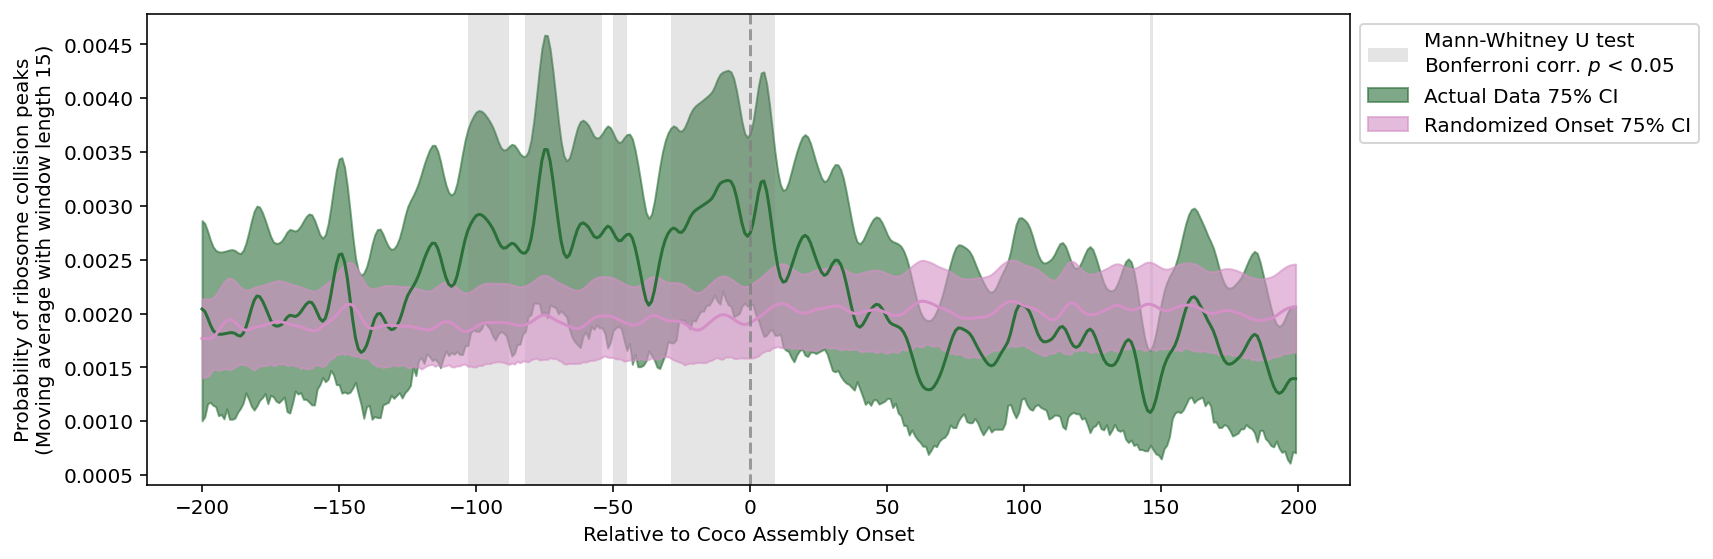

In [23]:
palette = sns.color_palette("cubehelix", 2)
plt.figure(figsize=(12,4))
x_data = np.array(range(-flank, flank))
a1 = smooth_array(np.nanmean(metag, axis=0), 15, "hanning")
a2 = smooth_array(np.nanmean(metag_average, axis=0), 15, "hanning")

plt.plot(x_data, a1, alpha=1, color=palette[0])
plt.plot(x_data, a2, alpha=1, color=palette[1])
plt.fill_between(x_data, smooth_array(bootstrap_ci[0], 15, "flat"), smooth_array(bootstrap_ci[1], 15, "hanning"), 
                 alpha=0.6, color=palette[0], label="Actual Data 75% CI", zorder=0)
plt.fill_between(x_data,smooth_array(bootstrap_ci_random[0], 15, "flat"), smooth_array(bootstrap_ci_random[1], 15, "hanning"), 
                 alpha=0.6, color=palette[1], label="Randomized Onset 75% CI")
for i_rng, rng in enumerate(signif_rnges):
    plt.axvspan(rng[0] - flank, rng[1] - flank, color="gray", alpha=0.20, zorder=0, linewidth=0,
                label="Mann-Whitney U test\nBonferroni corr. $p$ < 0.05" if i_rng == 0 else "")

plt.axvline(0, color="gray", alpha=0.75, linestyle = "--")
plt.xlabel("Relative to Coco Assembly Onset")
plt.ylabel("Probability of ribosome collision peaks\n(Moving average with window length 15)")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Mati-Kai's Example Gene

Sixtymers enrichment before the onset

Winner: dsig
Onset: 957


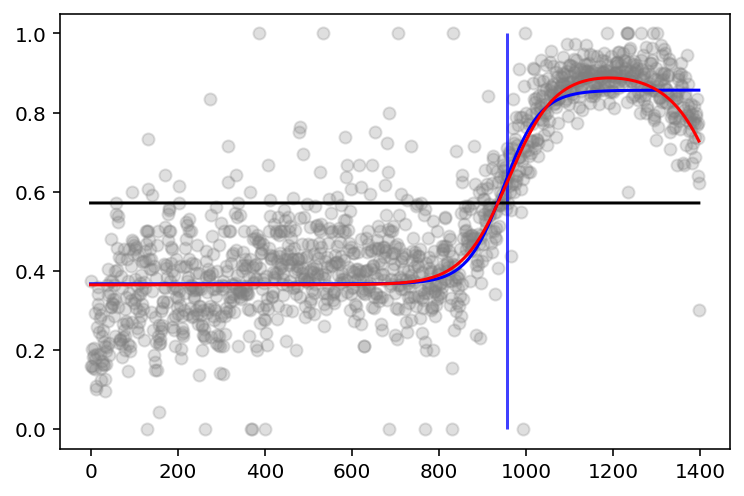

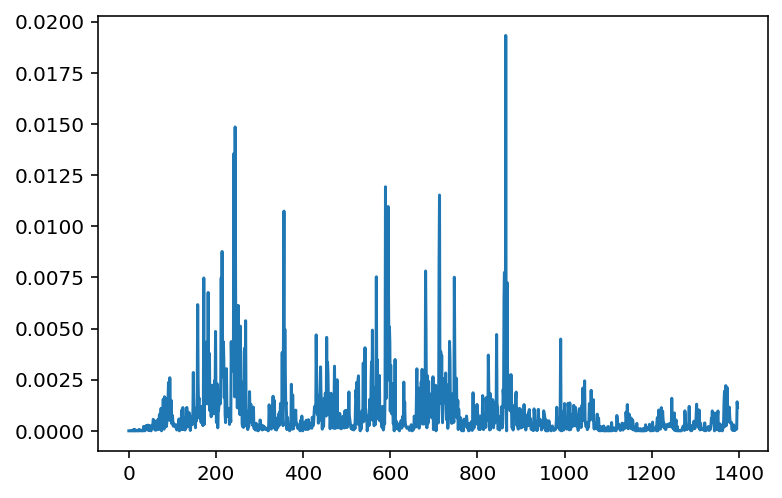

Peaks: [243 594 714 865]


In [24]:
# VIMENTIN
gene_id = "ENSG00000026025"
ons = gene_onset[gene_id]

I.riboseq_coco.plot_result(gene_id)
plt.show()
plt.plot(I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id) / I.riboseq_sixtymers.background.calculate_rpm_genes(gene_id))
plt.show()
print(f"Peaks: {gene_collision[gene_id]}")

## Why random onset cases are not horizontal line

In [25]:
data_plot = list()
for gene_id in I.gene_list:
    rpkm_bac = I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id)
    rpkm_exp = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
    if rpkm_bac > 0.01 and rpkm_exp > 0.01:
        data_plot.append([gene_lengths[gene_id], rpkm_exp / rpkm_bac])
data_plot = np.array(data_plot).T
print(data_plot.shape)

(2, 13798)


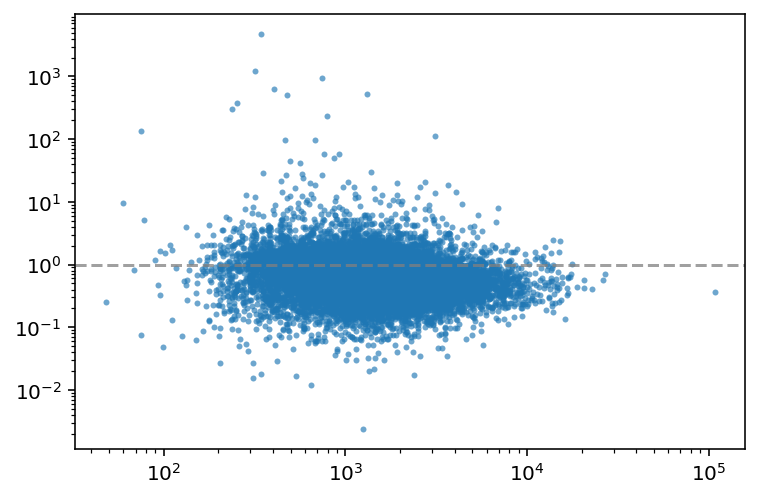

In [26]:
plt.scatter(data_plot[0], data_plot[1], linewidths=0, marker=".", alpha=0.65)
plt.axhline(1, color="gray", alpha=0.75, linestyle = "--")
plt.yscale("log")
plt.xscale("log")

Because the shorter genes tends to have more sixtymers / total translatome rpkm values. Since we normalize the sixtymers data with total translatome rpkm data, the values coming from shorter genes become more and more important. These short genes have impact on the middle points in the metagene profile, but not the edges. Edge average is therefore lower than the middle average in metagene profiles.

## Different Sigmoidal Curve Shapes

In [12]:
slope_inflection_onset = dict()
for gene_id in gene_onset:
    if not np.isnan(gene_onset[gene_id]):
        curve_derivative = np.gradient(I.riboseq_coco.calculate_curve(gene_id))
        slope_inflection_onset[gene_id] = curve_derivative[gene_onset[gene_id]]

/home/kai/HDD_Kemal/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1975: RuntimeWarning: overflow encountered in exp
  ((1 - i_final) / (1 + np.exp(-a_2 * (x - (i_mid + i_dist)))) + i_final)
/home/kai/HDD_Kemal/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1970: RuntimeWarning: overflow encountered in exp
  return (i_max - i_init) / (1 + np.exp(-a * (x - i_mid))) + i_init
/home/kai/HDD_Kemal/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1974: RuntimeWarning: overflow encountered in exp
  return ((i_max - i_init) / (1 + np.exp(-a_1 * (x - i_mid))) + i_init) * \


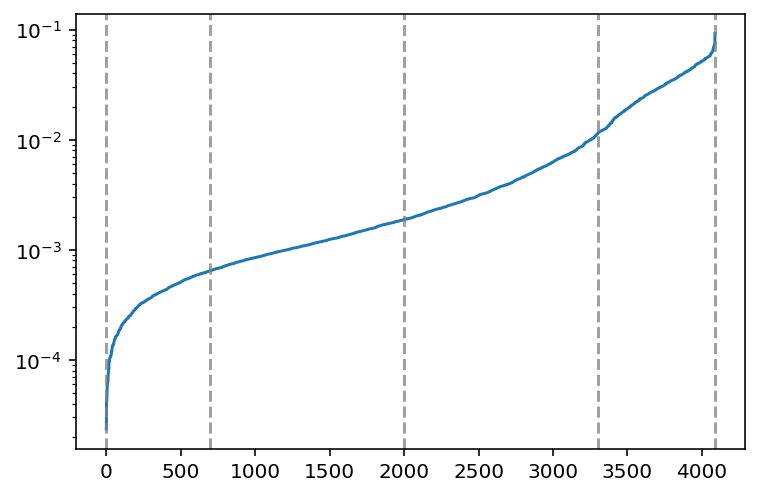

Intervals:
(2.3652785642591656e-05, 0.0006477509730286046)
(0.0006477509730286046, 0.0018787209944410854)
(0.0018787209944410854, 0.011381215137507866)
(0.011381215137507866, 0.09215917956834394)


In [13]:
k=np.array(list(slope_inflection_onset.values()))
plt.plot(np.sort(k))
m1, m5 = 0, len(k)
m2, m3, m4 = 700, 2000, 3300

plt.axvline(m1, color="gray", alpha=0.75, linestyle = "--")
plt.axvline(m2, color="gray", alpha=0.75, linestyle = "--")
plt.axvline(m3, color="gray", alpha=0.75, linestyle = "--")
plt.axvline(m4, color="gray", alpha=0.75, linestyle = "--")
plt.axvline(m5, color="gray", alpha=0.75, linestyle = "--")
plt.yscale("log")
plt.show()
print("Intervals:")
print((np.sort(k)[m1], np.sort(k)[m2]))
print((np.sort(k)[m2], np.sort(k)[m3]))
print((np.sort(k)[m3], np.sort(k)[m4]))
print((np.sort(k)[m4], np.sort(k)[m5-1]))
f1, f2, f3 = np.sort(k)[m2], np.sort(k)[m3], np.sort(k)[m4]

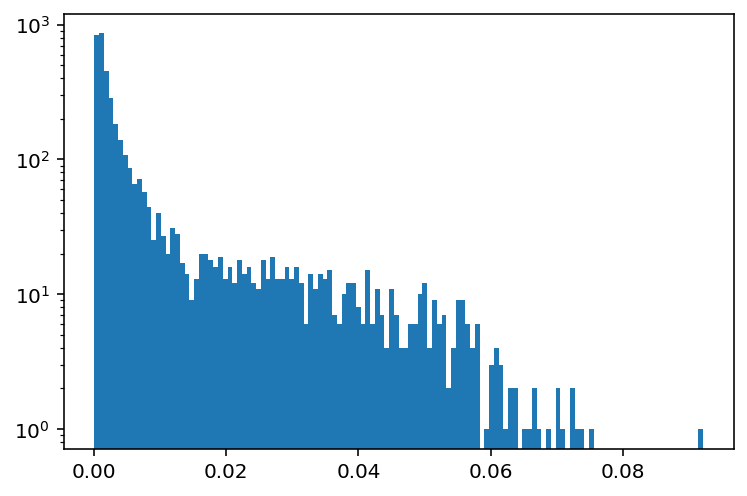

In [150]:
k = np.array(list(slope_inflection_onset.values()))
plt.hist(k, bins=128)
plt.yscale("log")
plt.show()

In [14]:
slope_class = gene_onset.copy()
for gene_id in gene_onset:
    if not np.isnan(gene_onset[gene_id]):
        m = slope_inflection_onset[gene_id]
        if m < f1:
            slope_class[gene_id] = 1
        elif m < f2:
            slope_class[gene_id] = 2
        elif m < f3:
            slope_class[gene_id] = 3
        else:
            slope_class[gene_id] = 4

In [679]:
rel_dist_temp = [[], [], [], []] # 4 different classes exist
m_close = list()
m_rpkm = list()
m_count = list()
m_length = list()
m_count_len = list()
for gene_id in I.gene_list:
    if not np.isnan(slope_class[gene_id]):
        col = gene_collision[gene_id]
        ons = gene_onset[gene_id]
        if len(col) == 0:
            continue
        addd = [i for i in col-ons if abs(i) < 800]
        rel_dist_temp[slope_class[gene_id] - 1].append(addd)
        m_close.append([slope_inflection_onset[gene_id], np.min(np.abs(col-ons))])
        m_count.append([slope_inflection_onset[gene_id], len(col)])
        m_length.append([slope_inflection_onset[gene_id], gene_lengths[gene_id]])
        m_count_len.append([slope_inflection_onset[gene_id], 1000 * len(col) / gene_lengths[gene_id]])
        m_rpkm.append([slope_inflection_onset[gene_id], I.riboseq_coco.experiment.calculate_rpkm_genes(gene_id)])
        
relative_distance = pd.DataFrame([[j for i in rel_dist_temp for j in i], [j for i in [[i+1] * len(rel_dist_temp[i]) for i in range(4)] for j in i]], 
                                 index=["Distance", "Class"]).T
m_close = np.array(m_close).T
m_count = np.array(m_count).T
m_length = np.array(m_length).T
m_rpkm = np.array(m_rpkm).T
m_count_len = np.array(m_count_len).T

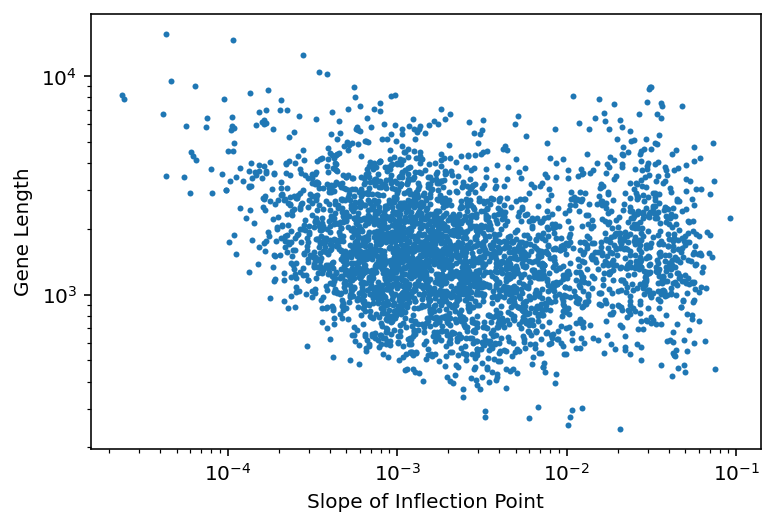

In [683]:
plt.scatter(m_length[0], m_length[1], linewidths=0, marker=".")
#plt.ylim(0,4)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Slope of Inflection Point")
plt.ylabel("Gene Length")
plt.show()

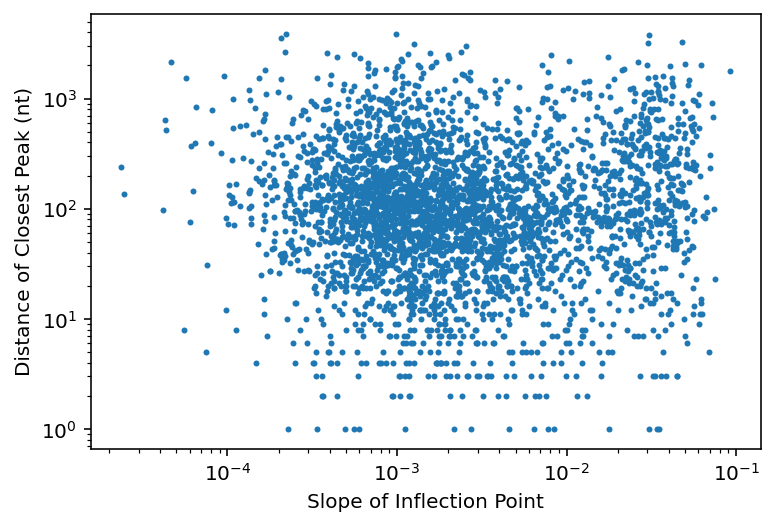

In [117]:
plt.scatter(m_close[0][m_close[1]!=0], m_close[1][m_close[1]!=0], linewidths=0, marker=".")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Slope of Inflection Point")
plt.ylabel("Distance of Closest Peak (nt)")
plt.show()

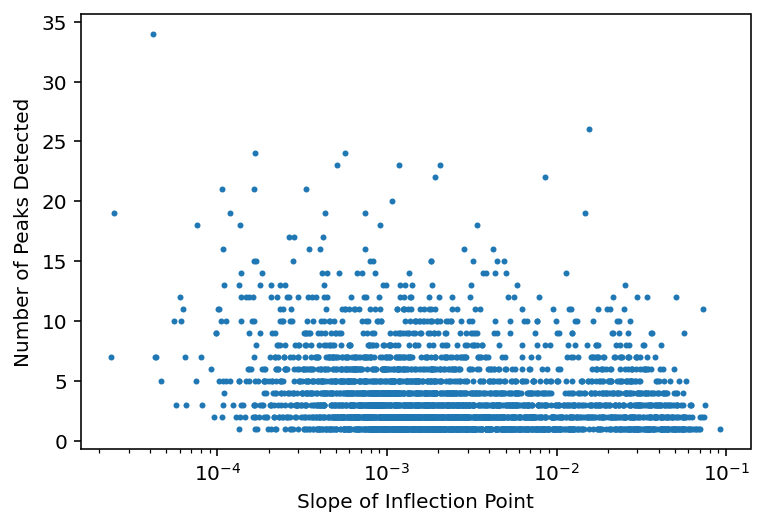

In [119]:
plt.scatter(m_count[0], m_count[1], linewidths=0, marker=".")
#plt.ylim(0,4)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("Slope of Inflection Point")
plt.ylabel("Number of Peaks Detected")
plt.show()

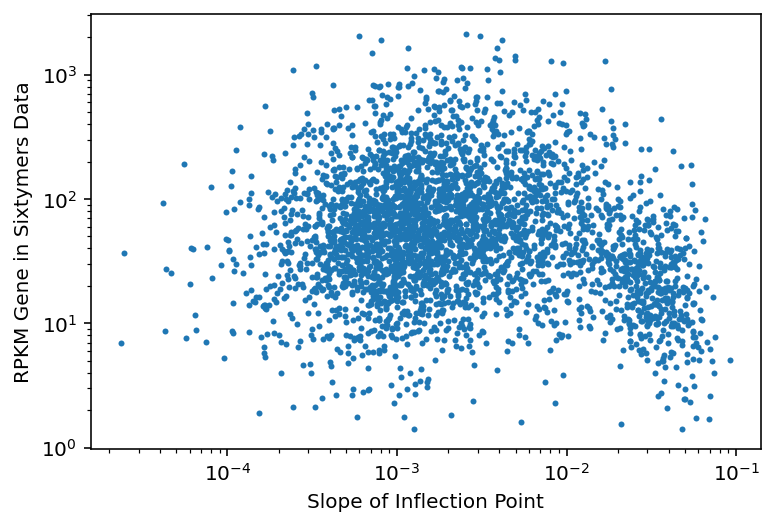

In [154]:
plt.scatter(m_rpkm[0], m_rpkm[1], linewidths=0, marker=".")
#plt.ylim(0,4)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Slope of Inflection Point")
plt.ylabel("RPKM Gene in Sixtymers Data")
plt.show()

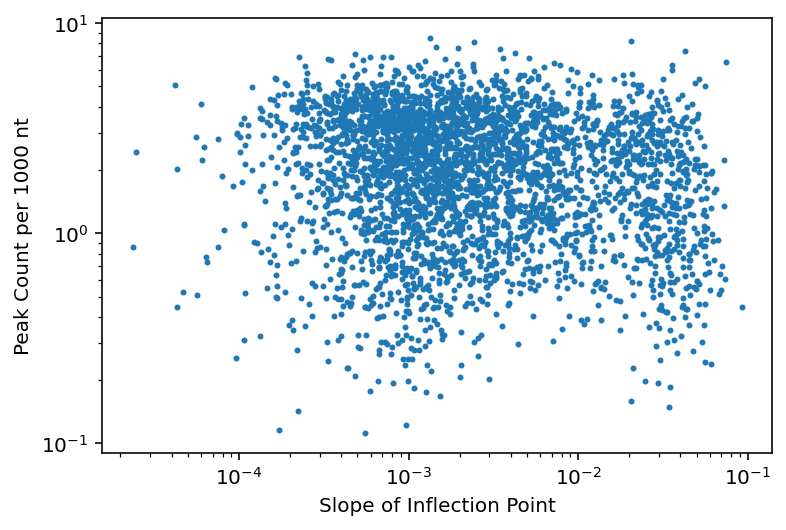

In [155]:
plt.scatter(m_count_len[0], m_count_len[1], linewidths=0, marker=".")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Slope of Inflection Point")
plt.ylabel("Peak Count per 1000 nt")
plt.show()

In [25]:
[len(i) for i in rel_dist_temp]

[649, 1122, 1080, 630]

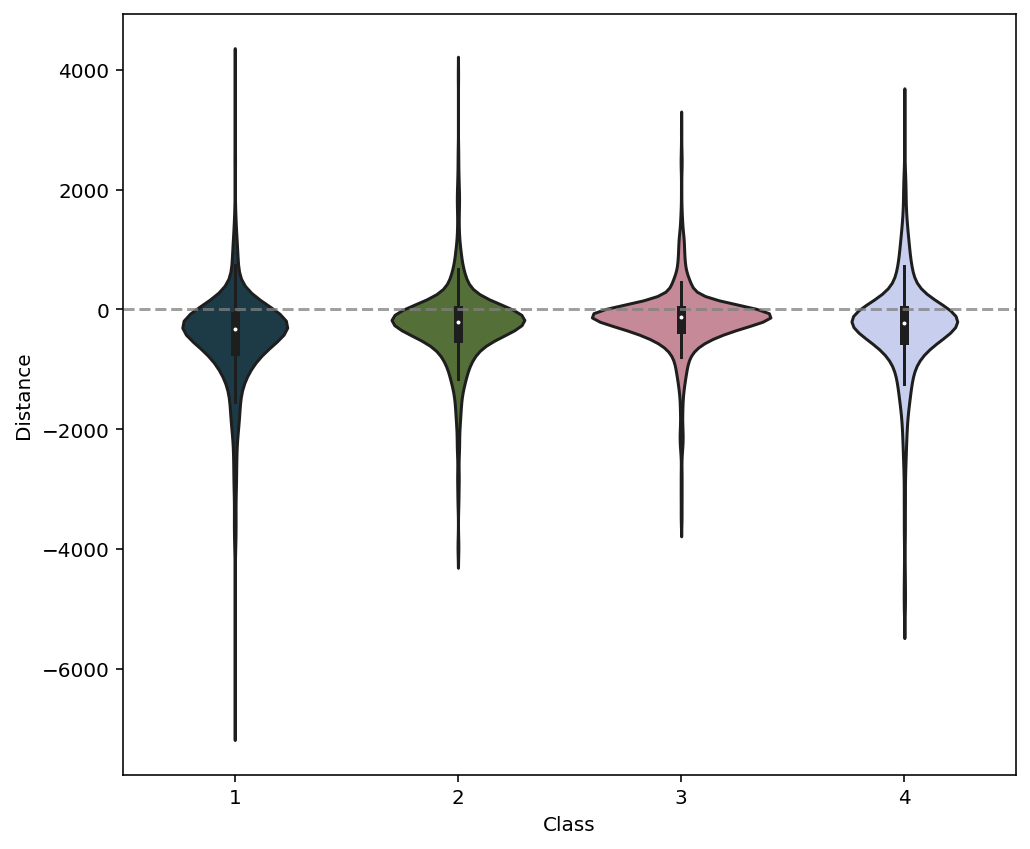

In [26]:
plt.figure(figsize=(8,7))
sns.violinplot(data=relative_distance, x="Class", y="Distance", palette="cubehelix", fliersize=0.25)
plt.axhline(0, color="gray", alpha=0.75, linestyle = "--")
#plt.ylim((-2750, +2750))

Studying with peaks seems to be quite imprecise and not clear
#### With Normalized Sixtymers Data

In [631]:
import skimage.measure
from astropy import convolution
sio = pd.DataFrame(np.array([[i, slope_inflection_onset[i]] for i in slope_inflection_onset]), columns=["GeneID", "Slope"])
sio["Slope"] = sio["Slope"].astype(float)
sio.sort_values(by=['Slope'], inplace=True)
gene_list_sorted = sio["GeneID"].to_list()

In [696]:
flank = 400
rpkm_threshold_for_sixtymers = 0.001
the_matrix = np.full((len(slope_inflection_onset), flank*2), np.nan)
ind = 0
for gene_id in gene_list_sorted:
    rpkm_background = I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id)
    ons = gene_onset[gene_id]
    if rpkm_background > rpkm_threshold_for_sixtymers:
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        normalized_sixtymers = exp_rpm_bs / rpkm_background
        start_position = max(0, ons-flank)
        start_offset = -min(0, ons-flank)
        marr = normalized_sixtymers[start_position: ons+flank]
        the_matrix[ind, start_offset: len(marr) + start_offset] = marr
        ind += 1
the_matrix = the_matrix.T

(800, 4089)
(200, 1023)


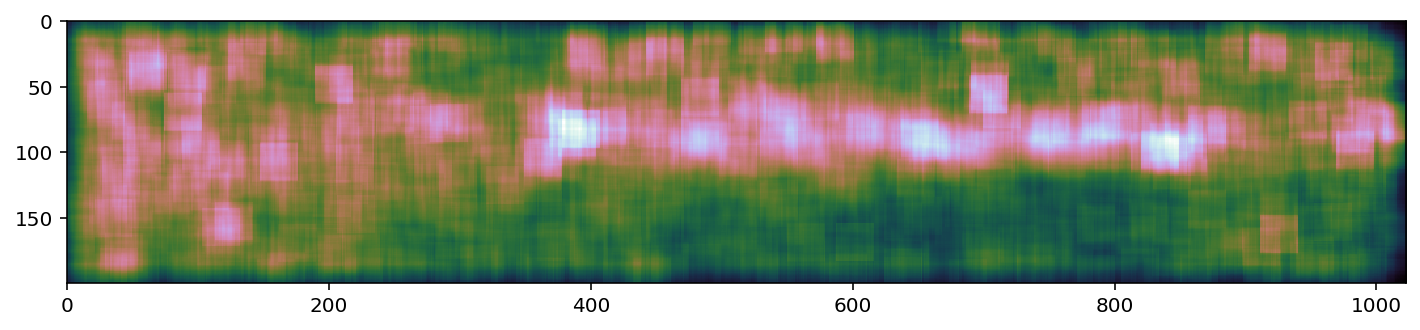

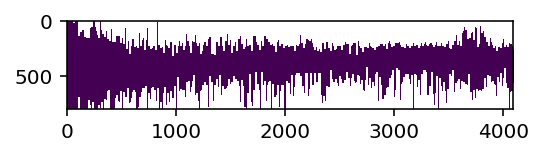

In [697]:
krnl = 29
a_matrix = skimage.measure.block_reduce(the_matrix, (4,4), np.nanmean)
a_matrix = convolution.convolve(a_matrix, np.ones((krnl, krnl)) / krnl )

print(the_matrix.shape)
print(a_matrix.shape)

plt.figure(figsize=(12,12))
plt.imshow(a_matrix, cmap='cubehelix', interpolation='nearest')
plt.show()
plt.figure(figsize=(4,4))
plt.imshow(the_matrix)
plt.show()

In [ ]:
# todo: x_tick_labels

## Collision peaks around onset versus remaining

In [611]:
associated_peaks = dict()
counts = 0
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    col = gene_collision[gene_id]
    if not np.isnan(ons):
        for c in col:
            if ons - 100 < c < ons + 25:
                associated_peaks[gene_id] = associated_peaks.get(gene_id, []) + [c]
                counts += 1

In [ ]:
print(f"Number of collision points at these posisitons: {counts}")

In [166]:
fl = 30
aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [167]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
expected_seq = ""
for gene_id in I.gene_list:
    best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
    expected_seq += I.protein_genome.db[best_transcript][1]
dfk_expected = pd.DataFrame([ProteinAnalysis(expected_seq).get_amino_acids_percent()] * (fl * 2), index=np.arange(-fl, fl))
del expected_seq

In [ ]:
fill_matrix = np.zeros((fl * 2, len(aa)))
for gene_id in associated_peaks:
    best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
    protein_seq = "."*fl + I.protein_genome.db[best_transcript][1] + "."*fl
    for nt_position in associated_peaks[gene_id]:
        aa_position = math.floor(nt_position / 3) + fl
        fpca = protein_seq[aa_position-fl: aa_position+fl]
        for i_fl in range(fl * 2):
            try:
                # Increase the relevant position with normalized intensity
                fill_matrix[i_fl, aa.index(fpca[i_fl])] += 1
            except ValueError:
                pass  # Raises ValueError for non-conventional amino acids or "."
dfk_observed = pd.DataFrame((fill_matrix.T / np.sum(fill_matrix, axis=1)).T, columns=aa, index=np.arange(-fl, fl))

In [ ]:
sonc = [stats.entropy(dfk_observed.iloc[i], dfk_expected.iloc[i]) for i in range(fl * 2)]
#plt.plot(np.arange(-fl, fl), sonc)
#plt.axvline(0, color="gray", alpha=0.75, linestyle = "--")
#plt.title("Information Content")

In [ ]:
import logomaker
to_plot = (np.log2(dfk_observed/ dfk_expected).T * sonc).T
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(to_plot, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood $\times$ Relative Entropy")
ss_logo.ax.set_xlabel("Relative to Ribosome A-site")
ss_logo.ax.set_title("Stalling Site Logo for Ribosome Peaks around Coco Assembly Onset", y=1.05, fontweight="bold")
plt.show()
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(np.log2(dfk_observed/ dfk_expected), flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood")
ss_logo.ax.set_xlabel("Relative to Ribosome A-site")
ss_logo.ax.set_title("Stalling Site Logo for Ribosome Peaks around Coco Assembly Onset", y=1.05, fontweight="bold")
plt.show()

#### Global Ribosome Collision Signature

In [168]:
fill_matrix = np.zeros((fl * 2, len(aa)))
for gene_id in gene_collision:
    best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
    protein_seq = "."*fl + I.protein_genome.db[best_transcript][1] + "."*fl
    for nt_position in gene_collision[gene_id]:
        aa_position = math.floor(nt_position / 3) + fl
        fpca = protein_seq[aa_position-fl: aa_position+fl]
        for i_fl in range(fl * 2):
            try:
                # Increase the relevant position with normalized intensity
                fill_matrix[i_fl, aa.index(fpca[i_fl])] += 1
            except ValueError:
                pass  # Raises ValueError for non-conventional amino acids or "."
dfk_observed = pd.DataFrame((fill_matrix.T / np.sum(fill_matrix, axis=1)).T, columns=aa, index=np.arange(-fl, fl))

INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/truetype/unifont/unifont_sample.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


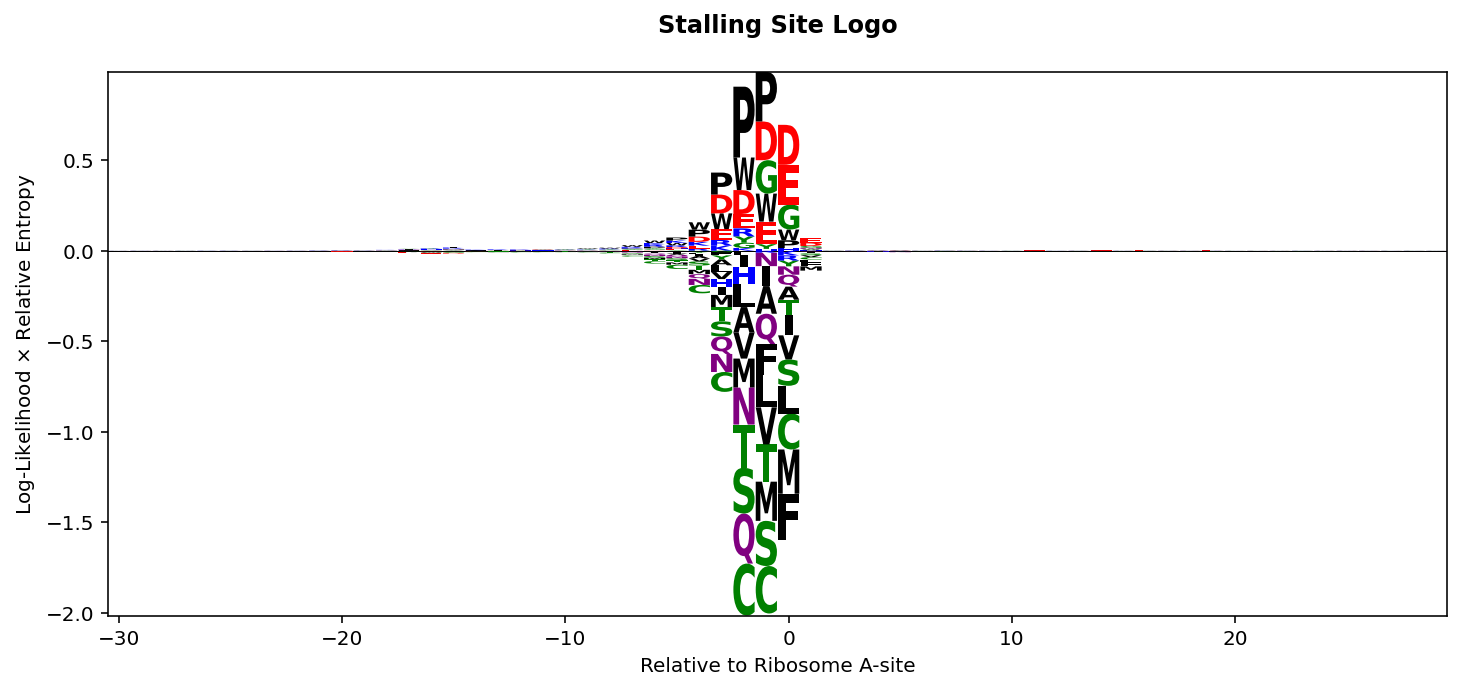

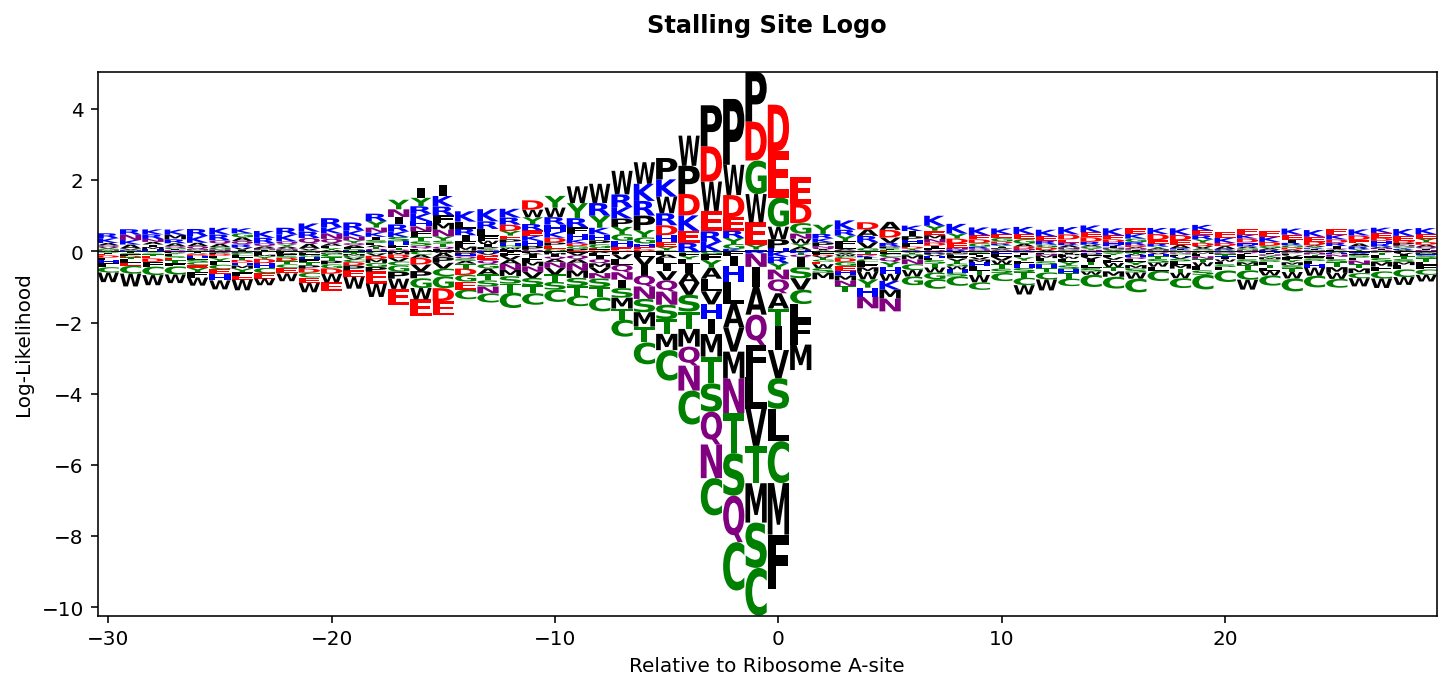

In [169]:
import logomaker
icont = [stats.entropy(dfk_observed.iloc[i], dfk_expected.iloc[i]) for i in range(fl * 2)]
log2_likelihood = np.log2(dfk_observed/ dfk_expected)
to_plot = (log2_likelihood.T * icont).T
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(to_plot, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood $\times$ Relative Entropy")
ss_logo.ax.set_xlabel("Relative to Ribosome A-site")
ss_logo.ax.set_title("Stalling Site Logo", y=1.05, fontweight="bold")
plt.show()
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(log2_likelihood, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood")
ss_logo.ax.set_xlabel("Relative to Ribosome A-site")
ss_logo.ax.set_title("Stalling Site Logo", y=1.05, fontweight="bold")
plt.show()

## Sequence Logo Scanning Across Proteome

In [171]:
m1 = 24
m2 = 8
sqzd = log2_likelihood.loc[-m1:m2,:]
kersh = m1 + m2 + 1

try:
    motif_exp_calcs, prot_triptle_sum = joblib.load(os.path.join(temp_repo_dir, "jupyter_motif_corr.joblib"))
except:
    motif_exp_calcs = dict()
    prot_triptle_sum = dict()
    for inddd, gene_id in enumerate(I.gene_list):
        if I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id) > 1:
            progress_bar(inddd, len(I.gene_list)-1, verbose=True)
            best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
            prot_seq = I.protein_genome.db[best_transcript][1]
            if "X" in prot_seq or "U" in prot_seq:
                continue
            signl = [np.nan] * m1

            for ind in range(len(prot_seq) + 1 - kersh):
                prot_substring = prot_seq[ind: ind + kersh]
                assert len(prot_substring) == kersh
                signl.append(np.nansum(np.diag(sqzd.iloc[:, [aa.index(i) for i in prot_substring]])))

            signl += [np.nan] * m2
            signl = np.array(signl)

            k0 = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
            k0 = k0 / I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id)  # it is always multiple of 3
            k0 = np.array([np.sum(k0[i: i+3]) for i in range(0, len(k0) - 2 , 3)])

            motif_exp_calcs[gene_id] = signl
            prot_triptle_sum[gene_id] = k0
    joblib.dump((motif_exp_calcs, prot_triptle_sum), os.path.join(temp_repo_dir, "jupyter_motif_corr.joblib"))

Progress: |████████████████████| 100.0% 

In [227]:
spearman_corr = dict()
pearson_corr = dict()
for gene_id in prot_triptle_sum:
    k0 = prot_triptle_sum[gene_id]
    signl = motif_exp_calcs[gene_id]
    try:
        k1 = smooth_array(k0[m1:-m2], 31, "hanning")
        k2 = smooth_array(2 ** signl[m1:-m2], 31, "hanning")
    except AssertionError:
        continue
    if np.sum(k1) == 0:
        continue
    k1, k2 = normalization(k1), normalization(k2)
    spearman_corr[gene_id] = stats.spearmanr(k1,k2)
    pearson_corr[gene_id] = stats.pearsonr(k1,k2)

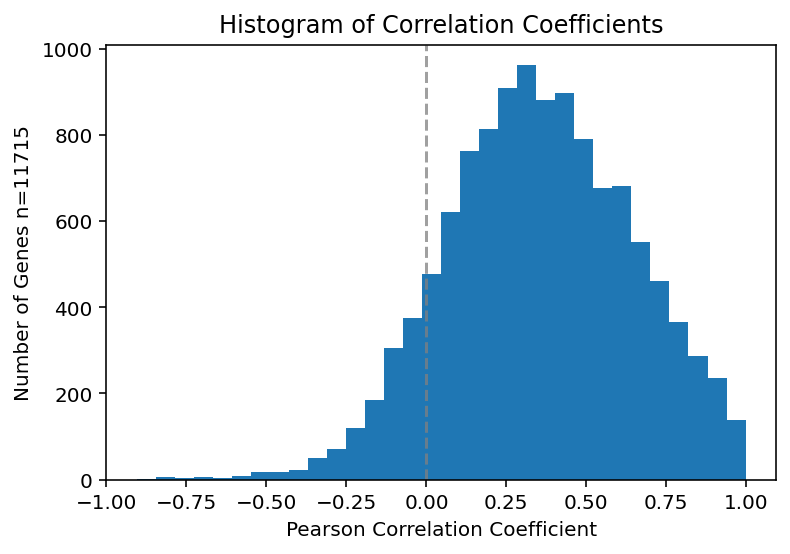

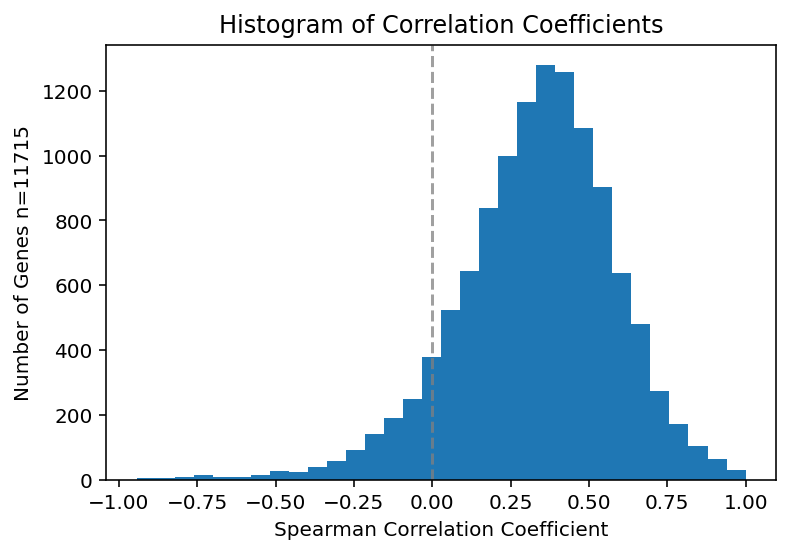

In [228]:
plt.figure(figsize=(6,4))
plt.hist(sorted([i for i,j in pearson_corr.values()]), bins=32)
plt.axvline(0, color="gray", alpha=0.75, linestyle = "--")
plt.title("Histogram of Correlation Coefficients")
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel(f"Number of Genes n={len(pearson_corr)}")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(sorted([i for i,j in spearman_corr.values()]), bins=32)
plt.axvline(0, color="gray", alpha=0.75, linestyle = "--")
plt.title("Histogram of Correlation Coefficients")
plt.xlabel("Spearman Correlation Coefficient")
plt.ylabel(f"Number of Genes n={len(spearman_corr)}")
plt.show()

(-0.15949136562506755, 0.8244012258066369)
0.3324549300907847
0.3513867274057737


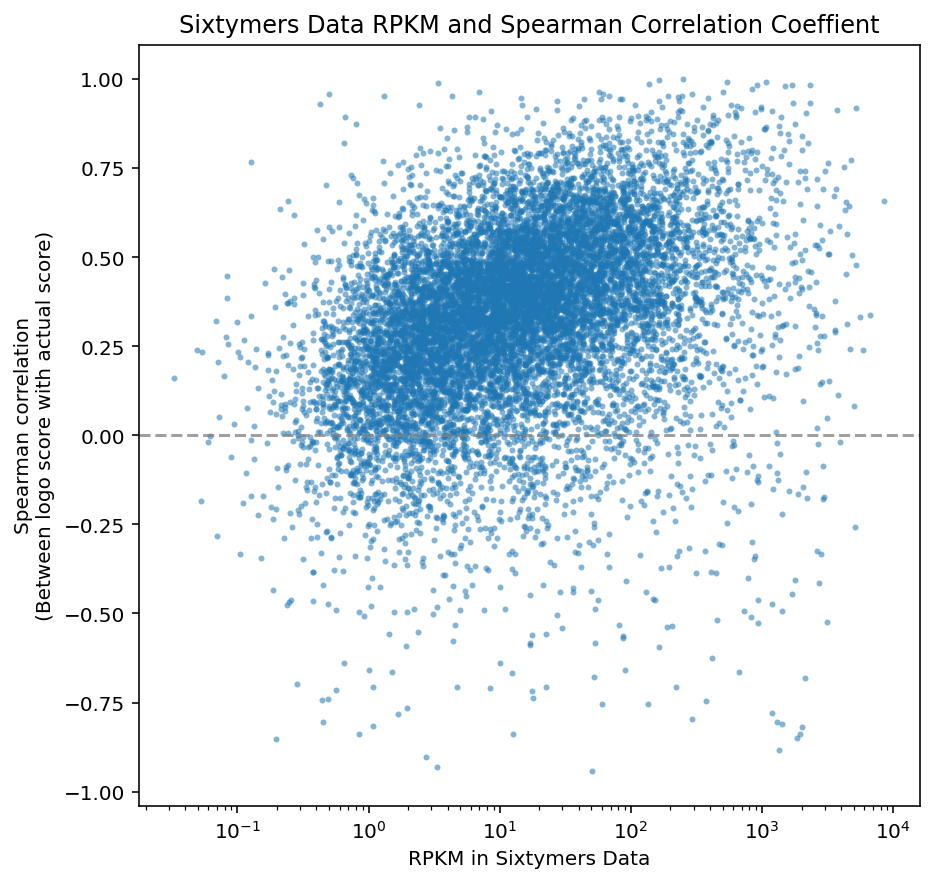

(-0.21401869889742348, 0.9216510086393781)
0.35381615487097734
0.3501651247531211


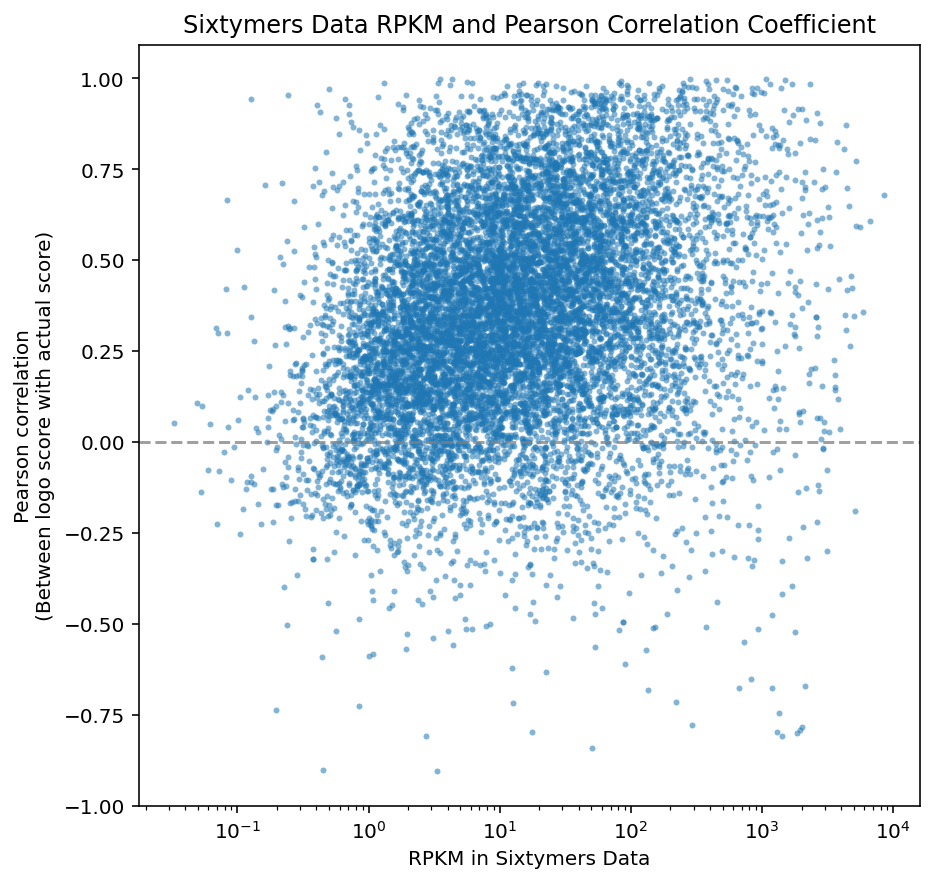

In [229]:
y=[spearman_corr[gene_id][0] for gene_id in spearman_corr]
x=[I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id) for gene_id in spearman_corr]
plt.figure(figsize=(7,7))
plt.scatter(x,y, marker=".", alpha=0.55, linewidths=0)
plt.xscale("log")
plt.axhline(0, color="gray", alpha=0.75, linestyle = "--")
plt.title("Sixtymers Data RPKM and Spearman Correlation Coeffient")
plt.xlabel("RPKM in Sixtymers Data")
plt.ylabel("Spearman correlation\n(Between logo score with actual score)")
ci=stats.norm.interval(0.95, loc=np.nanmean(y), scale=np.nanstd(y))
print(ci)
print(np.nanmean(y))
print(np.nanmedian(y))
plt.show()

y=[pearson_corr[gene_id][0] for gene_id in pearson_corr]
x=[I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id) for gene_id in pearson_corr]
plt.figure(figsize=(7,7))
plt.scatter(x,y, marker=".", alpha=0.55, linewidths=0)
plt.xscale("log")
plt.axhline(0, color="gray", alpha=0.75, linestyle = "--")
plt.title("Sixtymers Data RPKM and Pearson Correlation Coefficient")
plt.xlabel("RPKM in Sixtymers Data")
plt.ylabel("Pearson correlation\n(Between logo score with actual score)")
ci=stats.norm.interval(0.95, loc=np.nanmean(y), scale=np.nanstd(y))
print(ci)
print(np.nanmean(y))
print(np.nanmedian(y))
plt.show()

(-0.15949136562506755, 0.8244012258066369)
0.3324549300907847
0.3513867274057737


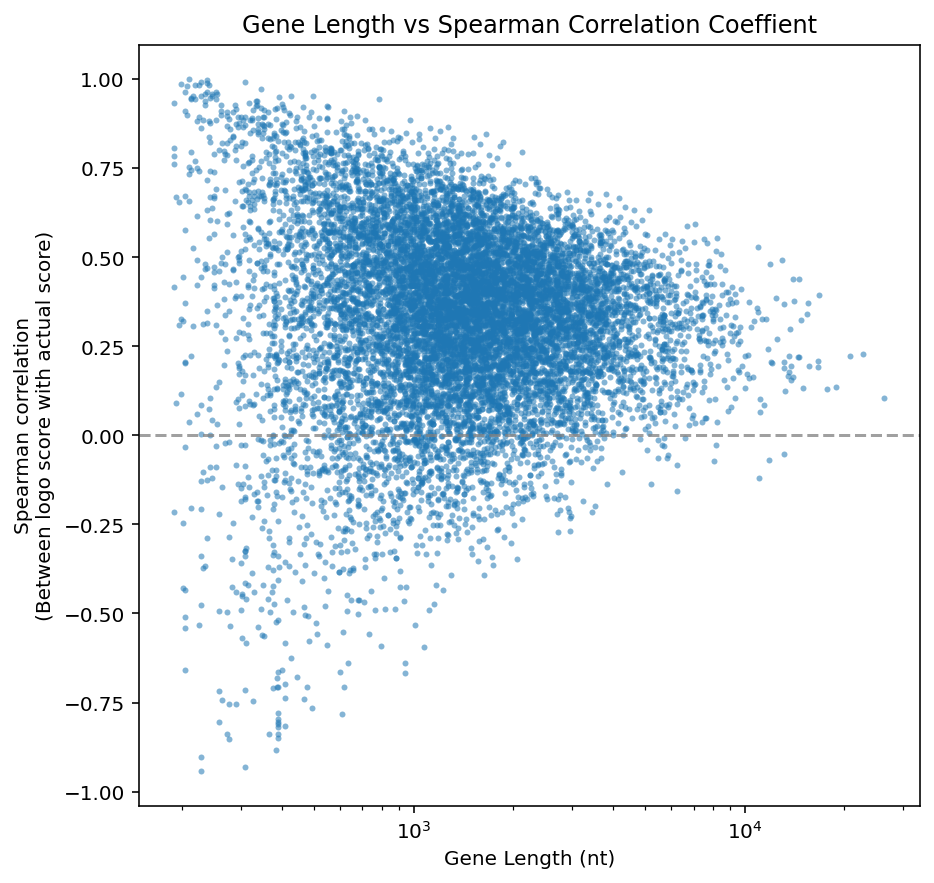

In [230]:
corr = spearman_corr
y=[corr[gene_id][0] for gene_id in corr]
x=[gene_lengths[gene_id] for gene_id in corr]
plt.figure(figsize=(7,7))
plt.scatter(x,y, marker=".", alpha=0.55, linewidths=0)
plt.xscale("log")
plt.axhline(0, color="gray", alpha=0.75, linestyle = "--")
plt.title("Gene Length vs Spearman Correlation Coeffient")
plt.xlabel("Gene Length (nt)")
plt.ylabel("Spearman correlation\n(Between logo score with actual score)")
ci=stats.norm.interval(0.95, loc=np.nanmean(y), scale=np.nanstd(y))
print(ci)
print(np.nanmean(y))
print(np.nanmedian(y))
plt.show()

In [234]:
highly_correlated = [i for i in spearman_corr if spearman_corr[i][0] > 0.3]
print(highly_correlated[40:45])
print(len(highly_correlated))

['ENSG00000005175', 'ENSG00000005187', 'ENSG00000005189', 'ENSG00000005194', 'ENSG00000005206']
6961


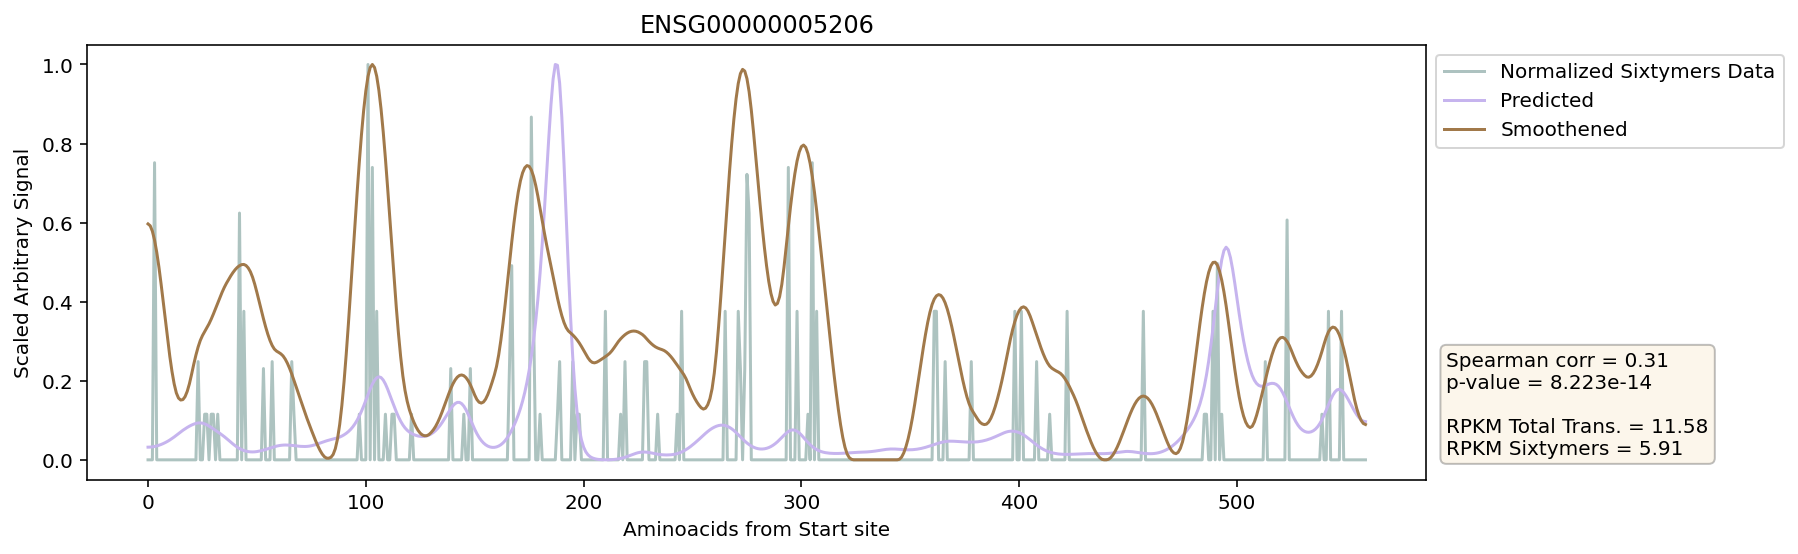

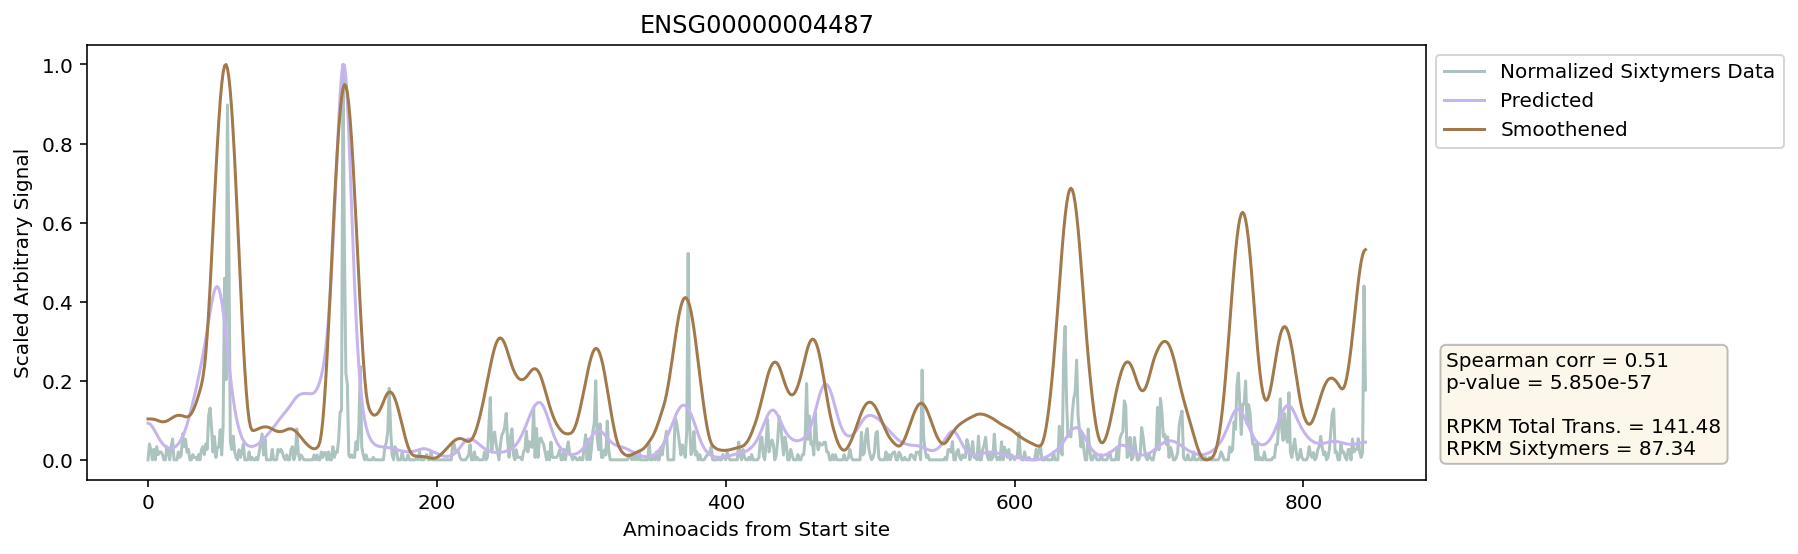

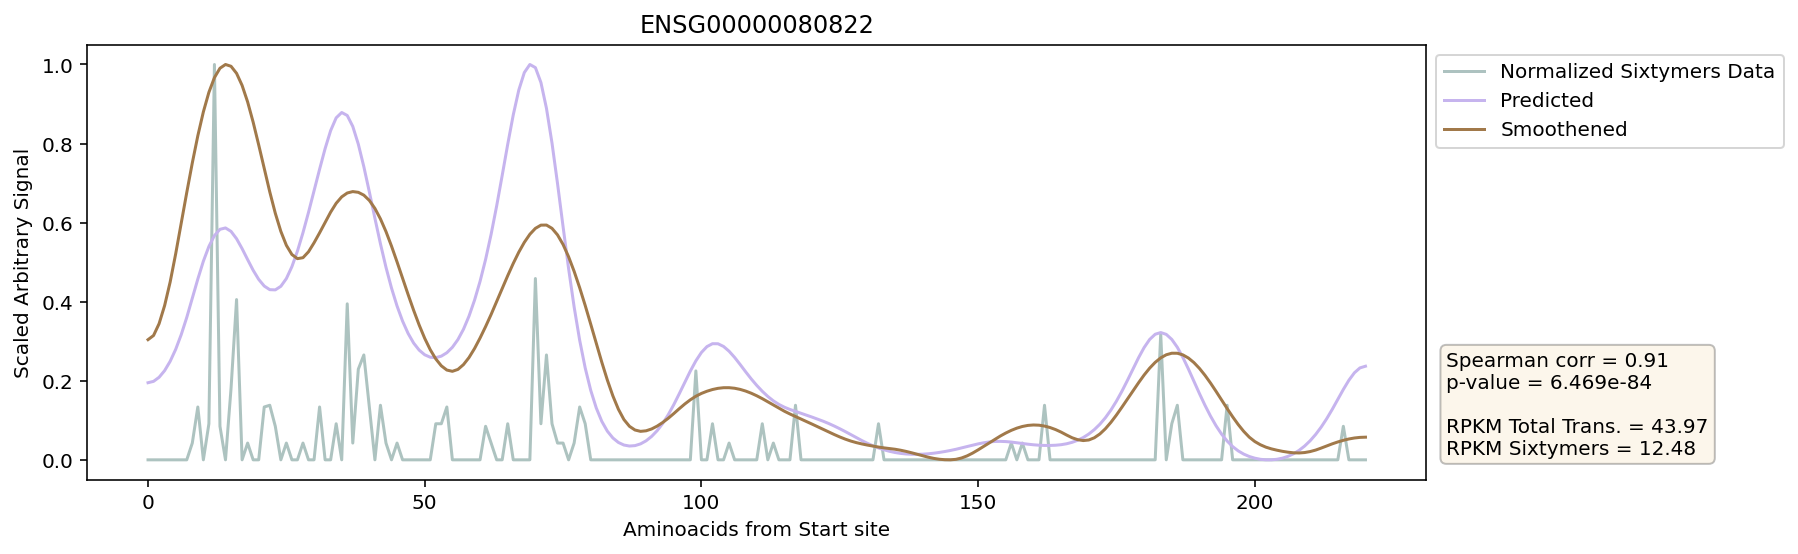

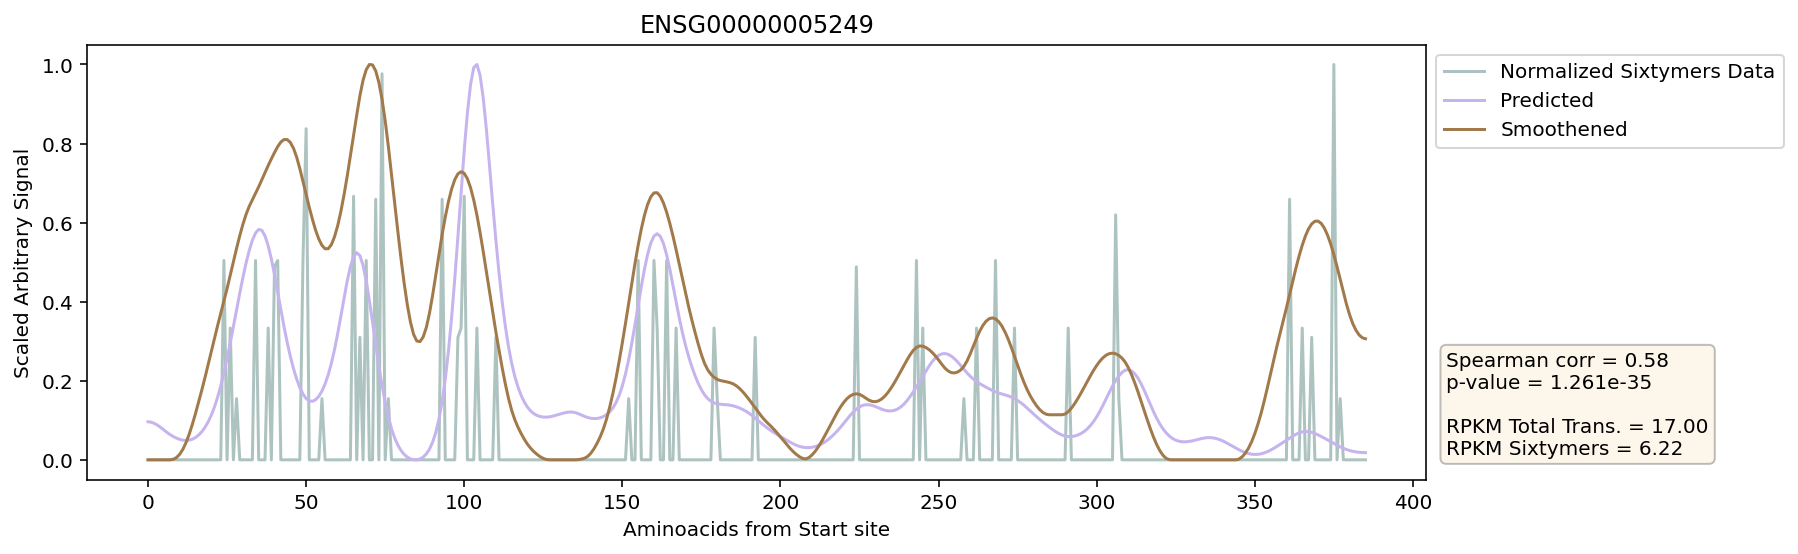

In [239]:
for gene_id in ["ENSG00000005206", "ENSG00000004487", "ENSG00000080822", "ENSG00000005249"]:
    #gene_id = highly_correlated[i]

    palette = sns.color_palette("cubehelix", 3)
    a1=2**smooth_array(motif_exp_calcs[gene_id][m1:-m2], 35, "hanning")
    a2=smooth_array(prot_triptle_sum[gene_id][m1:-m2], 35, "hanning")
    b1=prot_triptle_sum[gene_id][m1:-m2]

    fig, ax = plt.subplots(1,1,figsize=[12,4])
    plt.plot(normalization(b1), label="Normalized Sixtymers Data", color=palette[0], alpha=0.35)
    plt.plot(normalization(a1), label="Predicted", color=palette[2])
    plt.plot(normalization(a2), label="Smoothened", color=palette[1])


    corr, pval = stats.spearmanr(normalization(a1), normalization(a2))
    rpkm_gene_b = I.riboseq_sixtymers.background.calculate_rpkm_genes(gene_id)
    rpkm_gene_e = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)

    ax.text(1.015, 0.05, "Spearman corr = %.2f\np-value = %.3e\n\nRPKM Total Trans. = %.2f\nRPKM Sixtymers = %.2f" % (corr, pval, rpkm_gene_b, rpkm_gene_e), 
                transform=ax.transAxes, verticalalignment='bottom', horizontalalignment="left", alpha=1,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.25))
    plt.xlabel("Aminoacids from Start site")
    plt.ylabel("Scaled Arbitrary Signal")
    plt.title(gene_id)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

## Sequence Logo False Positives and False Negatives
Note that presumably not all sequence with a similar sequence logo cause collision) 

In [ ]:
# Get average score and graph of collision at detected collision points

In [ ]:
collision_scores = list()
estimateds = list()
for inddd, gene_id in enumerate(motif_exp_calcs):
    actual = smooth_array(prot_triptle_sum[gene_id][m1:-m2], 31, "hanning")
    estimated = smooth_array(2**motif_exp_calcs[gene_id][m1:-m2], 31, "hanning")
    collision_points = np.floor(gene_collision[gene_id] / 3 - m1)
    for i in collision_points:
        i = int(i)
        try:
            collision_scores.append([actual[i], estimated[i]])
        except IndexError:
            pass
    estimateds.extend(list(estimated))
collision_scores = np.array(collision_scores)
estimateds = np.array(estimateds)

In [ ]:
# median of predicted score in actual collision peaks.
psacp = np.nanmedian(collision_scores, axis=0)
#psacp = np.nanpercentile(collision_scores, 15, axis=0)
print(psacp)
psacp = psacp[1]

fig, ax = plt.subplots(1,2,figsize=[12,4], sharey=True)
ax[0].hist(collision_scores.T[0], density=True)
ax[0].axvline(psacp, color="black")
ax[1].hist(estimateds, density=True)
ax[1].axvline(psacp, color="black")
ax[0].set_ylabel("Density")
ax[0].set_xlabel("Smoothened Estimated Score")
ax[0].set_title("Only for calculated collision peaks")
ax[1].set_title("For all positions")
ax[1].set_ylabel("Density")
ax[1].set_yscale("log")
ax[1].set_xlabel("Smoothened Estimated Score")
plt.show()

In [ ]:
# Get all other points where you have high similarity but no collision peaks. (False negatives)
# Plot metagene of these points
    # Conservation around these points

In [ ]:
len(motif_exp_calcs)

In [ ]:
gene_collision_estimated = dict()
for gene_id in motif_exp_calcs:
    estimated = smooth_array(2 ** motif_exp_calcs[gene_id][m1:-m2], 31, "hanning")
    peaks = find_peaks(estimated)[0]
    gene_collision_estimated[gene_id] = (peaks[estimated[peaks] > psacp] + m1) * 3
np.concatenate(list(gene_collision_estimated.values())).shape

In [ ]:
def true_positive_peaks(peaks_actual, peaks_estimated, offset=20):
    true_positive = list()
    for pe in peaks_estimated:
        for pa in peaks_actual:
            if pe - offset <= pa <= pe + offset:
                true_positive.append(pe)
    return true_positive

* Change below to I.gene_list to see plot below information content

In [ ]:
geneLIST = I.gene_list

high_signal_but_low_prob = dict()
high_signal_and_high_prob = dict()
for gene_id in gene_collision_estimated:
    if gene_id in geneLIST: # HERE!
        temp = true_positive_peaks(gene_collision_estimated[gene_id], gene_collision[gene_id])
        sap = [i for i in gene_collision[gene_id] if i not in temp]
        high_signal_and_high_prob[gene_id] = temp
        high_signal_but_low_prob[gene_id] = sap
print(np.concatenate(list(high_signal_and_high_prob.values())).shape)
print(np.concatenate(list(high_signal_but_low_prob.values())).shape)

In [ ]:
fill_matrix = np.zeros((fl * 2, len(aa)))
for gene_id in high_signal_but_low_prob:
    best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
    protein_seq = "."*fl + I.protein_genome.db[best_transcript][1] + "."*fl
    for nt_position in high_signal_but_low_prob[gene_id]:
        aa_position = math.floor(nt_position / 3) + fl
        fpca = protein_seq[aa_position-fl: aa_position+fl]
        for i_fl in range(fl * 2):
            try:
                # Increase the relevant position with normalized intensity
                fill_matrix[i_fl, aa.index(fpca[i_fl])] += 1
            except ValueError:
                pass  # Raises ValueError for non-conventional amino acids or "."
dfk_observed = pd.DataFrame((fill_matrix.T / np.sum(fill_matrix, axis=1)).T, columns=aa, index=np.arange(-fl, fl))
sonc1 = [stats.entropy(dfk_observed.iloc[i], dfk_expected.iloc[i]) for i in range(fl * 2)]

In [ ]:
to_plot = (np.log2(dfk_observed/ dfk_expected).T * sonc1).T

fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(to_plot, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood $\times$ Relative Entropy")
ss_logo.ax.set_xlabel("Relative to Ribosome A-site")
ss_logo.ax.set_title("Stalling Site Logo for Ribosome Peaks for False Positives (Collision peak but low estimation)", y=1.05, fontweight="bold")
plt.show()

fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(np.log2(dfk_observed/ dfk_expected), flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood")
ss_logo.ax.set_xlabel("Relative to Ribosome A-site")
ss_logo.ax.set_title("Stalling Site Logo for Ribosome Peaks for False Positives (Collision peak but low estimation)", y=1.05, fontweight="bold")
plt.show()

In [ ]:
fill_matrix = np.zeros((fl * 2, len(aa)))
for gene_id in high_signal_and_high_prob:
    best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
    protein_seq = "."*fl + I.protein_genome.db[best_transcript][1] + "."*fl
    for nt_position in high_signal_and_high_prob[gene_id]:
        aa_position = math.floor(nt_position / 3) + fl
        fpca = protein_seq[aa_position-fl: aa_position+fl]
        for i_fl in range(fl * 2):
            try:
                # Increase the relevant position with normalized intensity
                fill_matrix[i_fl, aa.index(fpca[i_fl])] += 1
            except ValueError:
                pass  # Raises ValueError for non-conventional amino acids or "."
dfk_observed = pd.DataFrame((fill_matrix.T / np.sum(fill_matrix, axis=1)).T, columns=aa, index=np.arange(-fl, fl))
sonc2 = [stats.entropy(dfk_observed.iloc[i], dfk_expected.iloc[i]) for i in range(fl * 2)]

In [ ]:
to_plot = (np.log2(dfk_observed/ dfk_expected).T * sonc2).T

fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(to_plot, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood $\times$ Relative Entropy")
ss_logo.ax.set_xlabel("Relative to Ribosome A-site")
ss_logo.ax.set_title("Stalling Site Logo for Ribosome Peaks for True Positives (Collision peak and high estimation)", y=1.05, fontweight="bold")
plt.show()

fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(np.log2(dfk_observed/ dfk_expected), flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood")
ss_logo.ax.set_xlabel("Relative to Ribosome A-site")
ss_logo.ax.set_title("Stalling Site Logo for Ribosome Peaks for True Positives (Collision peak and high estimation)", y=1.05, fontweight="bold")
plt.show()

In [ ]:
plt.plot(np.arange(-fl, fl), icont, label="All")
plt.plot(np.arange(-fl, fl), sonc1, label="True Positives")
plt.plot(np.arange(-fl, fl), sonc2, label="False Positives")
plt.axvline(0, color="gray", alpha=0.75, linestyle = "--")
plt.title("Information Content - All genes")
plt.ylabel("Shannon bit")
plt.xlabel("Relative to Ribosome A-site")
plt.legend()
plt.show()

In [ ]:
# Plot conservation around these regions

In [ ]:
# FALSE NEGATIVES: have high similarity but no collision peaks

In [ ]:
1

In [ ]:
# Searching Sequence Logo of Collision Sites around Coco Onset

# Conservation around Coco Onset

In [135]:
I.conservation_gerp = ConservationGerp(I.temp_repo_dir, I.organism, I.ensembl_release)

In [136]:
gerp_dict = dict()
for ind, gene_id in enumerate(I.gene_list):
    gerp_dict[gene_id] = I.conservation_gerp.get_best_transcript(gene_id, I.gene_info, I.protein_genome)
    if ind % 100 == 0 or ind == (len(I.gene_list) - 1):
        progress_bar(ind, len(I.gene_list) - 1, verbose=True)

Progress: |████████████████████| 100.0% 


In [137]:
number_of_offset = 0
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    if not np.isnan(ons):
        number_of_offset += 1
number_of_offset

7796

In [150]:
flank = 400
metag = np.full((number_of_offset, flank * 2), np.nan)
ind = 0
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    if not np.isnan(ons):
        gerp = gerp_dict[gene_id]
        start_position = max(0, ons-flank)
        start_offset = -min(0, ons-flank)
        marr = gerp[start_position: ons+flank]
        metag[ind, start_offset: len(marr) + start_offset] = marr
        ind += 1
ind

7796

In [151]:
onset_gene = 25
metag_average = np.full((number_of_offset * onset_gene, flank * 2), np.nan)
ind = 0
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    if not np.isnan(ons):
        for _ in range(onset_gene):
            ons = np.random.randint(gene_lengths[gene_id])
            gerp = gerp_dict[gene_id]
            start_position = max(0, ons-flank)
            start_offset = -min(0, ons-flank)
            marr = gerp[start_position: ons+flank]
            metag_average[ind, start_offset: len(marr) + start_offset] = marr
            ind += 1
ind

194900

- Showing that the data is not normally distributed.
- The reason why bootstrapping is used for CI, the reason why mannwhitneyu is used

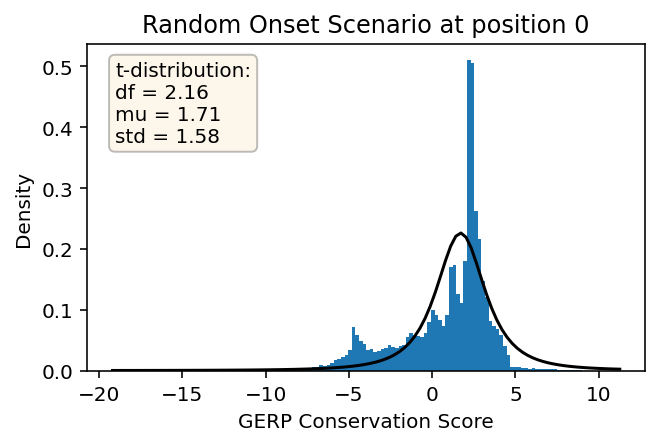

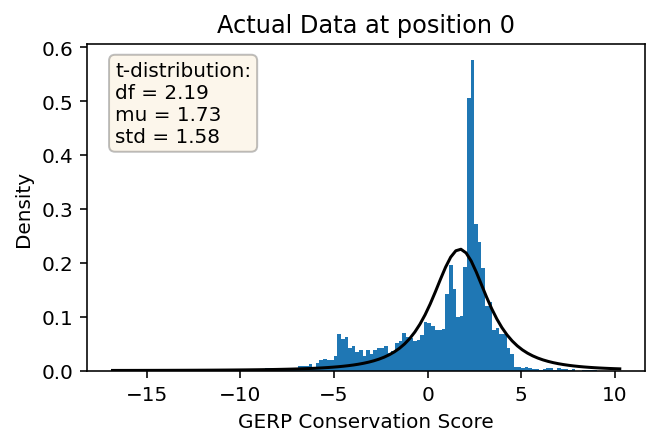

In [152]:
example_point = flank

for m, tit in zip([metag_average, metag],["Random Onset Scenario", "Actual Data"]):
    example_dist = m[:,example_point]
    example_dist = example_dist[~np.isnan(example_dist)]
    params = stats.t.fit(example_dist)
    fig, ax = plt.subplots(1,1,figsize=[5,3])
    plt.hist(example_dist, bins=128, density=True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.t.pdf(x, *params)
    plt.plot(x, p, 'k')
    ax.text(0.05, 0.95, "t-distribution:\ndf = %.2f\nmu = %.2f\nstd = %.2f" % params, 
            transform=ax.transAxes, verticalalignment='top', horizontalalignment="left", alpha=1,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.25))
    plt.title(f"{tit} at position {flank - example_point}")
    plt.ylabel("Density")
    plt.xlabel("GERP Conservation Score")
    plt.show()

Non-parametric statistical analysis. There is no need to assume that our observations, or the underlying populations, are normally distributed. Thanks to the Central Limit Theorem, the resampling distribution of the effect size will approach a normality.

In [153]:
m1 = np.array([smooth_array(i, 15, "hanning") for i in metag])
m2 = np.array([smooth_array(i, 15, "hanning") for i in metag_average])
significance = list()
for i in range (flank*2):
    progress_bar(i, flank*2 - 1, verbose=True)
    m1_l = m1[:,i][~np.isnan(m1[:,i])]
    m2_l = m2[:,i][~np.isnan(m2[:,i])]
    significance.append(stats.mannwhitneyu(m1_l, m2_l).pvalue < 0.05 / (flank * 2))
significance = np.array(significance).astype(int)
## Ranges for plotting
signif_rnges = list()
first_element = False
for ind, i in enumerate(significance):
    if not first_element and i == 0:
        continue
    elif not first_element and i == 1:
        first_element = ind
    elif i == 0 or ind == len(significance) - 1:
        signif_rnges.append([first_element, ind - 1])
        first_element = False
    elif i == 1:
        continue
print(signif_rnges)

Progress: |████████████████████| 100.0% 
[[165, 302], [397, 401], [412, 422]]


In [154]:
kk = 0.95 
bootstrap_ci = confidence_interval_calculate(metag, confidence=kk)
bootstrap_ci_random = confidence_interval_calculate(metag_average, confidence=1-((1-kk) / onset_gene))

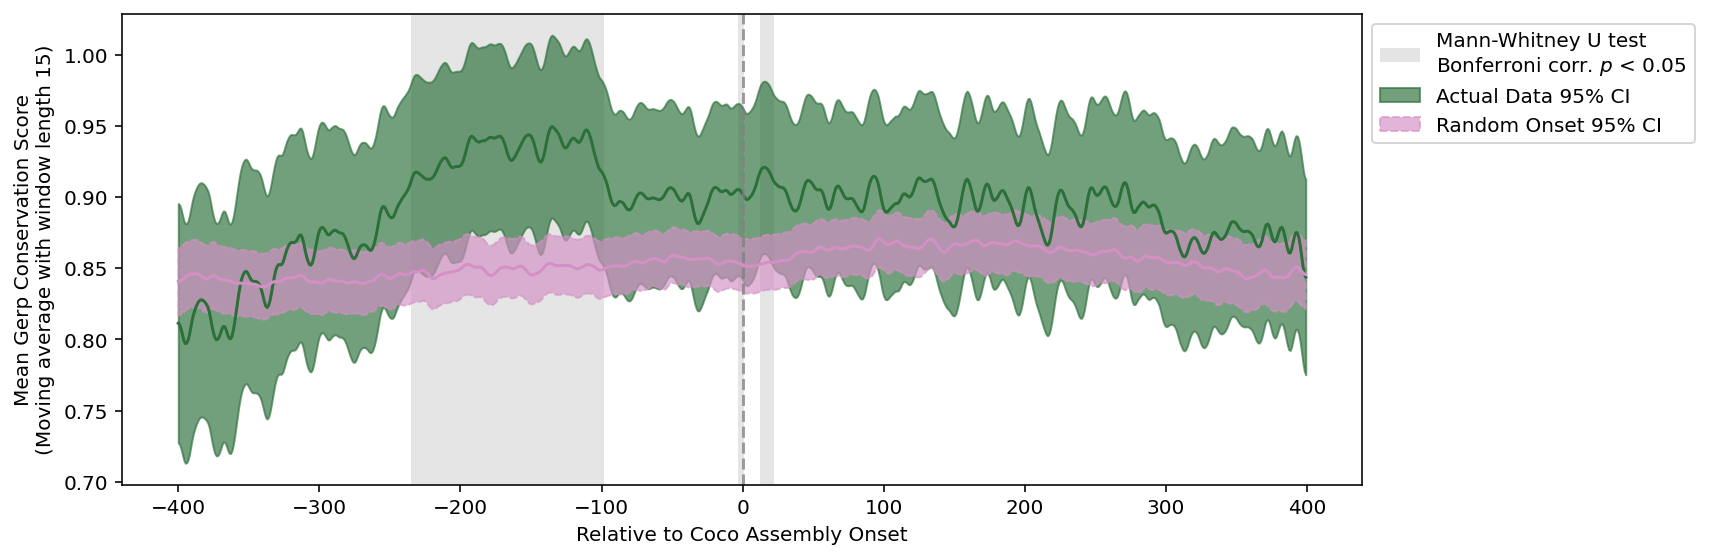

In [155]:
palette = sns.color_palette("cubehelix", 2)
plt.figure(figsize=(12,4))
x_data = np.array(range(-flank, flank))

plt.plot(x_data, smooth_array(np.nanmean(metag, axis=0), 15, "hanning"),
                color=palette[0], alpha=1)
plt.plot(x_data, smooth_array(np.nanmean(metag_average, axis=0), 15, "hanning"),
                color=palette[1], alpha=1)
plt.fill_between(x_data, smooth_array(bootstrap_ci[0],15, "hanning"), smooth_array(bootstrap_ci[1],15, "hanning"),
                color=palette[0], alpha=0.66, label="Actual Data 95% CI")
plt.fill_between(x_data, smooth_array(bootstrap_ci_random[0],15, "hanning"), smooth_array(bootstrap_ci_random[1],15, "hanning"),
                color=palette[1], alpha=0.66, linestyle="--", label="Random Onset 95% CI")
for i_rng, rng in enumerate(signif_rnges):
    plt.axvspan(rng[0] - flank, rng[1] - flank, color="gray", alpha=0.20, zorder=0, linewidth=0,
                label="Mann-Whitney U test\nBonferroni corr. $p$ < 0.05" if i_rng == 0 else "")
plt.axvline(0, color="gray", alpha=0.75, linestyle = "--")
plt.xlabel("Relative to Coco Assembly Onset")
plt.ylabel("Mean Gerp Conservation Score\n(Moving average with window length 15)")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Conservation around Collision Peaks

In [159]:
number_of_collisions = 0
for gene_id in gene_collision:
    number_of_collisions += len(gene_collision[gene_id])
number_of_collisions

34135

In [160]:
flank = 400
metag = np.full((number_of_collisions, flank * 2), np.nan)
ind = 0
for gene_id in gene_collision:
    gerp = gerp_dict[gene_id]
    col = gene_collision[gene_id]
    for ons in col:
        start_position = max(0, ons-flank)
        start_offset = -min(0, ons-flank)
        marr = gerp[start_position: ons+flank]
        metag[ind, start_offset: len(marr) + start_offset] = marr
        ind += 1
ind

34135

In [162]:
collison_gene = 25
flank = 400
metag_average = np.full((number_of_collisions * collison_gene, flank * 2), np.nan)
ind = 0
for gene_id in gene_collision:
    gerp = gerp_dict[gene_id]
    col = gene_collision[gene_id]
    for ons in col:
        for _ in range(collison_gene):
            ons = np.random.randint(gene_lengths[gene_id])
            start_position = max(0, ons-flank)
            start_offset = -min(0, ons-flank)
            marr = gerp[start_position: ons+flank]
            metag_average[ind, start_offset: len(marr) + start_offset] = marr
            ind += 1
ind

853375

In [163]:
m1 = np.array([smooth_array(i, 15, "hanning") for i in metag])
m2 = np.array([smooth_array(i, 15, "hanning") for i in metag_average])
significance = list()
for i in range (flank*2):
    progress_bar(i, flank*2 - 1, verbose=True)
    m1_l = m1[:,i][~np.isnan(m1[:,i])]
    m2_l = m2[:,i][~np.isnan(m2[:,i])]
    significance.append(stats.mannwhitneyu(m1_l, m2_l).pvalue < 0.05 / (flank * 2))
significance = np.array(significance).astype(int)
## Ranges for plotting
signif_rnges = list()
first_element = False
for ind, i in enumerate(significance):
    if not first_element and i == 0:
        continue
    elif not first_element and i == 1:
        first_element = ind
    elif i == 0 or ind == len(significance) - 1:
        signif_rnges.append([first_element, ind - 1])
        first_element = False
    elif i == 1:
        continue
print(signif_rnges)

Progress: |████████████████████| 100.0% 
[[357, 363], [386, 416]]


In [164]:
kk = 0.95 
bootstrap_ci = confidence_interval_calculate(metag, confidence=kk)
bootstrap_ci_random = confidence_interval_calculate(metag_average, confidence=1-((1-kk) / onset_gene))

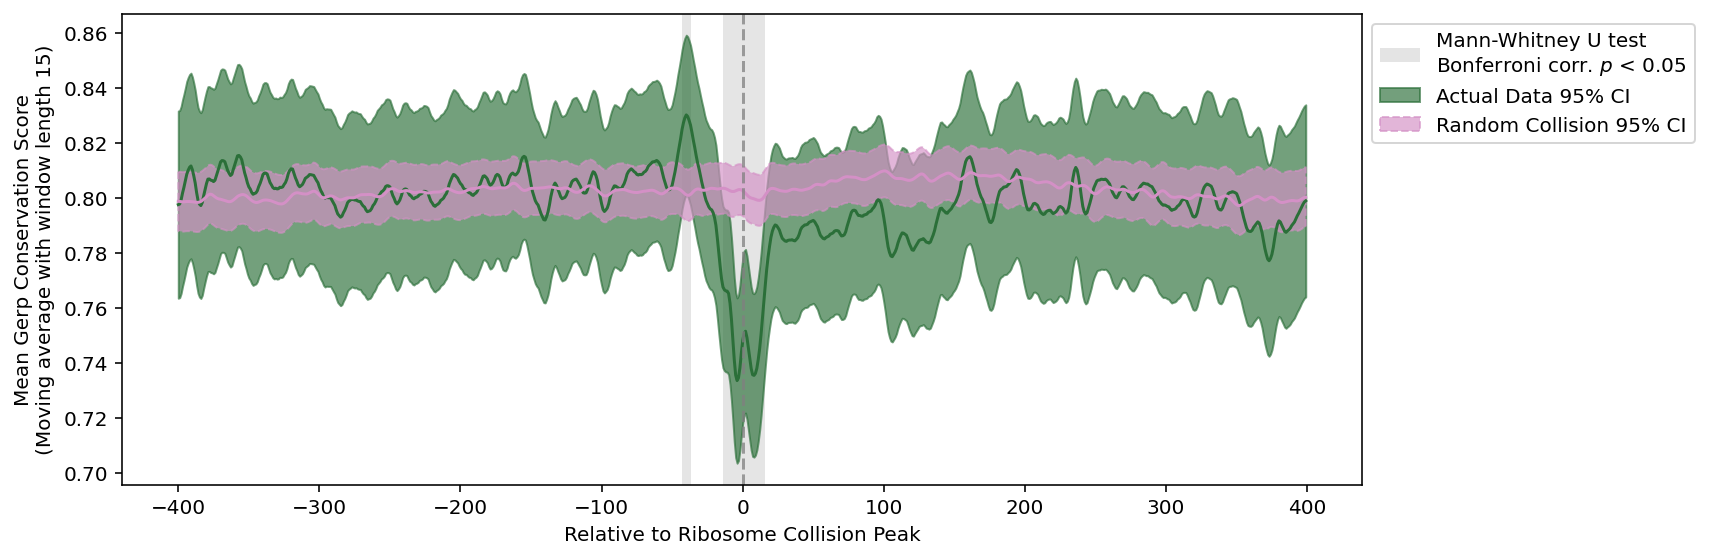

In [165]:
palette = sns.color_palette("cubehelix", 2)
plt.figure(figsize=(12, 4))
x_data = np.array(range(-flank, flank))
plt.plot(x_data, smooth_array(np.nanmean(metag, axis=0), 15, "hanning"),
                color=palette[0], alpha=1)
plt.plot(x_data, smooth_array(np.nanmean(metag_average, axis=0), 15, "hanning"),
                color=palette[1], alpha=1)
plt.fill_between(x_data, smooth_array(bootstrap_ci[0],15, "hanning"), smooth_array(bootstrap_ci[1],15, "hanning"),
                color=palette[0], alpha=0.66, label="Actual Data 95% CI")
plt.fill_between(x_data, smooth_array(bootstrap_ci_random[0],15, "hanning"), smooth_array(bootstrap_ci_random[1],15, "hanning"),
                color=palette[1], alpha=0.66, linestyle="--", label="Random Collision 95% CI")
for i_rng, rng in enumerate(signif_rnges):
    plt.axvspan(rng[0] - flank, rng[1] - flank, color="gray", alpha=0.20, zorder=0, linewidth=0,
                label="Mann-Whitney U test\nBonferroni corr. $p$ < 0.05" if i_rng == 0 else "")
plt.axvline(0, color="gray", alpha=0.75, linestyle = "--")
plt.xlabel("Relative to Ribosome Collision Peak")
plt.ylabel("Mean Gerp Conservation Score\n(Moving average with window length 15)")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Conservation at ribosome collision peaks coinciding with coco onset

# .

# .

# .

# .

# .

# .

# IDEAS

# .

# .

# .

# .

# .

# .

## Streching the Coco curve

In [378]:
def get_assembl_curve(gene_id):
    sgnl = I.riboseq_coco.calculate_curve(gene_id)
    drvt = np.gradient(sgnl)
    ons = gene_onset[gene_id]
    m = drvt[ons]
    karsi = sgnl[ons] - sgnl.min()
    komsu = karsi/m * 4
    return [max(0, math.floor(ons - komsu)), min(gene_lengths[gene_id], math.ceil(ons + komsu))]

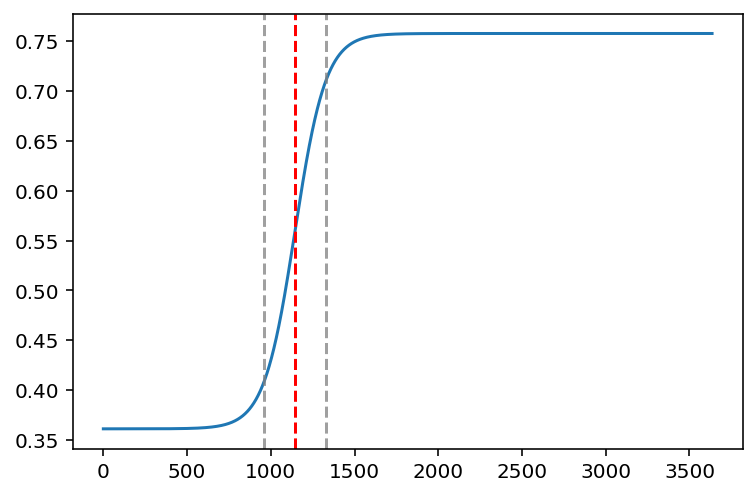

In [379]:
gene_id = "ENSG00000064651"
m1, m2 = get_assembl_curve(gene_id)
sgnl = I.riboseq_coco.calculate_curve(gene_id)
plt.plot(sgnl)
ons = gene_onset[gene_id]
plt.axvline(ons, color="red", alpha=1, linestyle = "--")
plt.axvline(m1, color="gray", alpha=0.75, linestyle = "--")
plt.axvline(m2, color="gray", alpha=0.75, linestyle = "--")
plt.show()
#I.riboseq_coco.plot_result(gene_id)

In [380]:
gene_assembl = {gene_id: get_assembl_curve(gene_id) for gene_id in gene_onset if not np.isnan(gene_onset[gene_id])}

/home/kai/KEMALINECIK/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1941: RuntimeWarning: overflow encountered in exp
  ((1 - i_final) / (1 + np.exp(-a_2 * (x - (i_mid + i_dist)))) + i_final)
/home/kai/KEMALINECIK/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1940: RuntimeWarning: overflow encountered in exp
  return ((i_max - i_init) / (1 + np.exp(-a_1 * (x - i_mid))) + i_init) * \
/home/kai/KEMALINECIK/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1936: RuntimeWarning: overflow encountered in exp
  return (i_max - i_init) / (1 + np.exp(-a * (x - i_mid))) + i_init


In [381]:
import scipy.interpolate as interp
def interpolate_5000(arr, toto=5000):
    arr1_interp = interp.interp1d(np.arange(arr.size), arr, kind="linear")
    return arr1_interp(np.linspace(0, arr.size-1, toto))

In [382]:
lst = []
for gene_id in I.gene_list:
    ons = gene_onset[gene_id]
    if not np.isnan(ons):
        m1, m2 = get_assembl_curve(gene_id)    
        signl = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)[m1:m2]
        signl = signl / I.riboseq_sixtymers.background.calculate_rpm_genes(gene_id)
        lst.append(list(interpolate_5000(signl)))
lst=np.array(lst)

In [395]:
repeat=10
lst_ar=np.zeros(lst.shape) 
for _ in range(repeat):
    lst_r = []
    for gene_id in I.gene_list:
        ons = gene_onset[gene_id]
        if not np.isnan(ons):
            m1, m2 = get_assembl_curve(gene_id)    
            signl_r = np.random.choice(normalized_sixtymers_random, m2-m1)
            lst_r.append(list(interpolate_5000(signl_r))) 
    lst_ar += np.array(lst_r)
lst_ar = lst_ar / repeat

/home/kai/KEMALINECIK/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1941: RuntimeWarning: overflow encountered in exp
  ((1 - i_final) / (1 + np.exp(-a_2 * (x - (i_mid + i_dist)))) + i_final)
/home/kai/KEMALINECIK/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1940: RuntimeWarning: overflow encountered in exp
  return ((i_max - i_init) / (1 + np.exp(-a_1 * (x - i_mid))) + i_init) * \
/home/kai/KEMALINECIK/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure/main.py:1936: RuntimeWarning: overflow encountered in exp
  return (i_max - i_init) / (1 + np.exp(-a * (x - i_mid))) + i_init


In [403]:
repeat=5
lst_ars=np.zeros(lst.shape) 
for _ in range(repeat):
    lst_rs = []
    for gene_id in I.gene_list:
        ons = gene_onset[gene_id]
        if not np.isnan(ons):
            m1 = np.random.randint(0, gene_lengths[gene_id] / 3 * 2) 
            m2 = np.random.randint(m1+14, gene_lengths[gene_id])
            signl = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)[m1:m2]
            signl = signl / I.riboseq_sixtymers.background.calculate_rpm_genes(gene_id)
            lst_rs.append(list(interpolate_5000(signl))) 
    lst_ars += np.array(lst_rs)
lst_ars = lst_ars / repeat

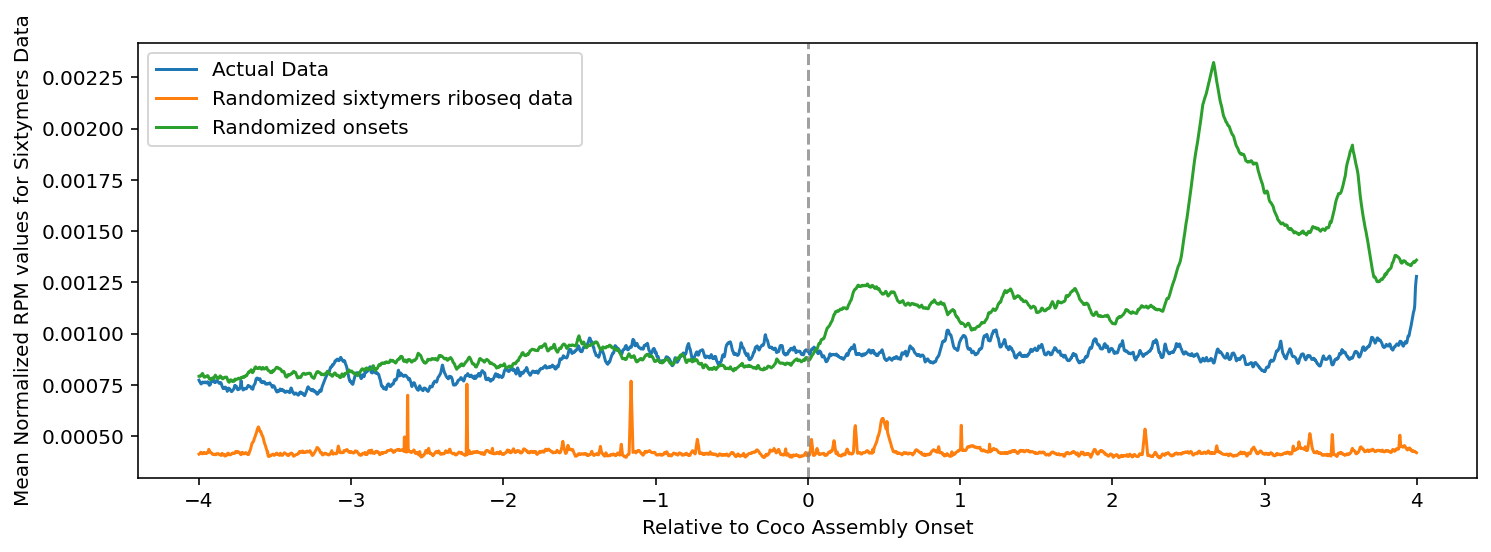

In [404]:
plt.figure(figsize=(12,4))
x_data = np.arange(-4, 4, 8/5000)
plt.plot(x_data, np.mean(lst, axis=0), label="Actual Data")
plt.plot(x_data, np.mean(lst_ar, axis=0), label="Randomized sixtymers riboseq data")
plt.plot(x_data, np.mean(lst_ars, axis=0), label="Randomized onsets")
plt.axvline(0, color="gray", alpha=0.75, linestyle = "--")
plt.xlabel("Relative to Coco Assembly Onset")
plt.ylabel("Mean Normalized RPM values for Sixtymers Data")
plt.legend()
plt.show()

## Look for sequence logo everywhere

* go for the collision peaks which does not show the logo
* go for the sequence similar to logo but does not show collision peak

For example, check GERP conservation scores in and around these regions

## Investigating collision peaks on coco, the shape of the fitting?

In [10]:
m=list(associated_peaks.keys())
print(f"Number of genes involved in the Coco-Sixtymer relationship based on detected collison peaks: {len(m)}")

print(f"\nThese genes has following statistics in for RPKM ({len(m)}):")
rpkms_of_these_genes = [I.riboseq_sixtymers.background.calculate_rpkm_genes(i) for i in m]
print(f"Mean: {np.mean(rpkms_of_these_genes)}")
print(f"Std Dev: {np.std(rpkms_of_these_genes)}")
print(f"Median: {np.median(rpkms_of_these_genes)}")

print(f"\nAll Genes ({len(I.gene_list)}):")
rpkms_of_these_genes = [I.riboseq_sixtymers.background.calculate_rpkm_genes(i) for i in I.gene_list]
print(f"Mean: {np.mean(rpkms_of_these_genes)}")
print(f"Std Dev: {np.std(rpkms_of_these_genes)}")
print(f"Median: {np.median(rpkms_of_these_genes)}")

msa = [i for i in I.gene_list if not np.isnan(gene_onset[i])]
print(f"\nGenes which fited Coco ({len(msa)}):")
rpkms_of_these_genes = [I.riboseq_sixtymers.background.calculate_rpkm_genes(i) for i in msa]
print(f"Mean: {np.mean(rpkms_of_these_genes)}")
print(f"Std Dev: {np.std(rpkms_of_these_genes)}")
print(f"Median: {np.median(rpkms_of_these_genes)}")

Number of genes involved in the Coco-Sixtymer relationship based on detected collison peaks: 620

These genes has following statistics in for RPKM (620):
Mean: 163.1563404194835
Std Dev: 326.01236702475535
Median: 55.22335557456464

All Genes (22524):
Mean: 40.506679251459744
Std Dev: 155.06101207215647
Median: 1.7091719641796888

Genes which fited Coco (7796):
Mean: 107.24722428322525
Std Dev: 247.17198543924593
Median: 35.91412299221416


Winner: dsig
Onset: 212


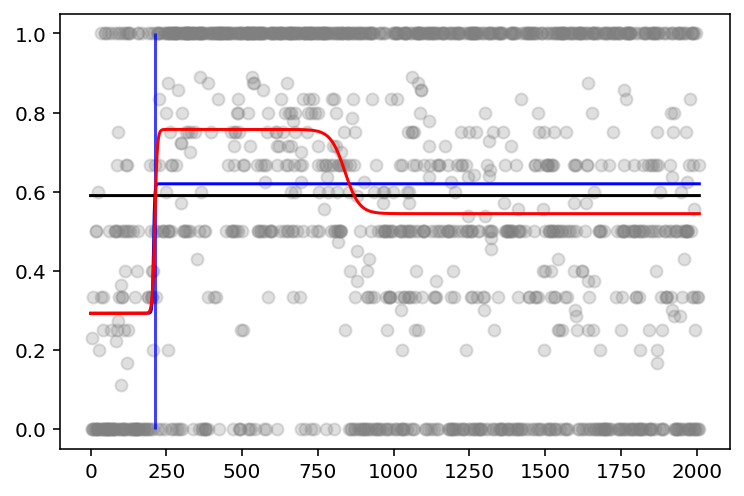

In [12]:
I.riboseq_coco.plot_result(ma[145])

In [345]:
gene_collision[ma[145]]

array([ 877, 1316])

## K-modes clustering of ribosome collision sites

In [90]:
chem_dict = dict()
for aa, chem in (("GCTYS", "Pol"),
("DE", "Aci"),
("KHR", "Bas"),
("UX.", np.nan),
("QN", "Neu"),
("AMILVFPW", "Hyd")):
    for a in aa:
        chem_dict[a] = chem

In [91]:
coll_region = list()
fl = 20
for gene_id in gene_collision:
    best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
    protein_seq = "."*fl + I.protein_genome.db[best_transcript][1] + "."*fl
    for nt_position in gene_collision[gene_id]:
        aa_position = math.floor(nt_position / 3) + fl
        fpca = list(protein_seq[aa_position-fl: aa_position+fl])
        #fpca = [chem_dict[a] for a in fpca]
        coll_region.append(fpca)
coll_region = np.array(coll_region)

In [94]:
from kmodes.kmodes import KModes
km = KModes(n_clusters=2, max_iter=100, init='cao', n_init=1, verbose=1)
clusters = km.fit_predict(coll_region)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 590835.0


# Motif Discovery Tool for Coco Onset

1

In [15]:
len([i for i in gene_onset.values() if not np.isnan(i) and i > 90])

6920

Gene  Onset [codons]  High_conf  Low_conf  Expression [RPKM]
0       AAAS             155        1.0     False           0.121248
1       AACS             101        1.0     False           0.023634
2      AADAT             186        0.0      True           0.005600
3       AAR2             107        1.0     False           0.061421
4      AARS2             214        0.0      True           0.031557
...      ...             ...        ...       ...                ...
4125  ZSWIM6             827        1.0     False           0.015511
4126    ZUP1             424        0.0      True           0.021439
4127    ZW10             227        1.0     False           0.050309
4128   ZWINT             193        1.0     False           0.256218
4129  ZYG11B              86        0.0      True           0.027807

[4130 rows x 5 columns]